In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from plotter import *
from easyesn.optimizers import GradientOptimizer
from easyesn import PredictionESN
from easyesn import BaseESN
# note: you must make this change in the easyesn code
# https://github.com/kalekiu/easyesn/issues/12
from easyesn.optimizers import GridSearchOptimizer
from easyesn import helper as hlp


""" NOTES:
    This file provides mechanisms to:
    A) Data Processing
        1) Load trajectories from csv files ( file must contain columns 'x', 'y')
        2) Create a trajectory from a trajectory generator (see more documentation in respective function)
        3) Load a generator from a csv file
        4) Load a set of feeders from a csv file
        5) Generate a matrix of place cell activations (row=place cell, column=time_index) 
           pc activation computed according to following formula:
                 e^( log(K) * ||pos - pc_center||^2 / r^2  )
           where 
                r is the place cell's radius
                K is the place cell's activation value at the radius
    
    B) Plot data
        Imports functionalities from 'plotter.py' which uses library matplotlib
"""


# CONSTANTS
PC_VALUE_AT_RADIUS = 0.6#0.8 # 0.3  # 0.2 activation value (constant K in pc activation formula)


def load_path(file_name):
    """" load csv fle specifying a path
         file must contain at least columns 'x' and 'y'
    """
    return pd.read_csv(file_name, delim_whitespace=True)
    # return sequence[['x', 'y']].to_numpy()


def load_generator(file_name):
    """" load csv fle specifying a path generator
             file must contain at least columns 'x', 'y' and 'steps'
        """
    return pd.read_csv(file_name, delim_whitespace=True)


def generate_path(generator):
    """ Generate a path using a generator
        'generator' is a pandas data frame containing at least 3 columns 'x' 'y' and 'steps'
        Column 'steps' indicate the number of step to reach the following way point (the
        value in the last row is ignored since it is the last point in the path)
    """

    # convert data to numpy arrays
    xy = generator[['x', 'y']].to_numpy()  # waypoints
    steps = generator['steps'].to_numpy()  #

    # interpolate each segment
    # endpoint=False will avoid repeating the last coordinate of each segment
    interpolator = lambda m_tuple: np.linspace(*m_tuple, endpoint=False)
    data = zip(xy[:-1], xy[1:], steps[:-1])
    path = np.concatenate(list(map(interpolator, data)) + [[xy[-1]]])
    return pd.DataFrame(path, columns=['x', 'y'])


def load_feeders(file_name):
    """"Function to load a set of feeders"""
    return pd.read_csv(file_name, delim_whitespace=True)[['x', 'y']]


def load_place_cells(file_name):
    """" Load csv fle specifying a set of place cells
         file must contain at least columns 'x', 'y' and 'placeradius'
    """
    return pd.read_csv(file_name, delim_whitespace=True)
    # return pcs[['x', 'y']].to_numpy(), pcs['placeradius'].to_numpy()


def calc_activation_matrix(path, pcs):
    """ Calculate a matrix containing the activation of all place cells for all times.
        Each row represents a place cell, while columns represent the time index.
        Both 'pos' and 'pcs' are data frames containing the path and the set of place cells.
    """
    # get number of pcs and position in path
    num_pcs = len(pcs)
    num_pos = len(path)

    # convert data to numpy to operate
    radii = pcs['placeradius'].to_numpy()
    pcs = pcs[['x', 'y']].to_numpy()
    pos = path[['x', 'y']].to_numpy()

    # replicate the position vector by the number of place cells for easy operations
    pos_tile = pos.reshape(1, -1, 2)
    pos_all = np.tile(pos_tile, (num_pcs, 1, 1))

    # replicate the place cells and radii by the number of positions for easy operations
    pcs_tile = pcs.reshape(-1, 1, 2)
    pcs_all = np.tile(pcs_tile, (1, num_pos, 1))
    radii_all = np.tile(radii.reshape((-1, 1)), (1, num_pos))

    # calculate the activations (see description of formula at the top of this file)
    delta = pos_all - pcs_all
    delta2 = (delta * delta).sum(2)
    
    r2 = radii_all * radii_all
    exponents = np.log(PC_VALUE_AT_RADIUS) * delta2 / r2
    activations = np.exp(exponents)
    return activations







Using Numpy backend.


In [2]:
def is_shapechanger(neurondata):
    data=neurondata['valye'].tolist()
    ef = (data[0]+data[3])/2
    mf = (data[1]+data[4])/2
    lf = (data[2]+data[5])/2
    es = (data[6]+data[9])/2
    ms = (data[7]+data[10])/2
    ls = (data[8]+data[11])/2
    em = (data[12]+data[15])/2
    mm = (data[13]+data[16])/2
    lm = (data[14]+data[17])/2
    if ef > mf:
        test1 = 100
    else:
        test1=200
    if mf > lf:
        test1 = test1 + 10
    else:
        test1 = test1 + 20
    if ef > lf:
        test1 = test1 + 1
    else:
        test1 = test1 + 2

    if es > ms:
        test2 = 100
    else:
        test2=200
    if ms > ls:
        test2 = test2 + 10
    else:
        test2 = test2 + 20
    if es > ls:
        test2 = test2 + 1
    else:
        test2 = test2 + 2

    if em > mm:
        test3 = 100
    else:
        test3=200
    if mm > lm:
        test3 = test3 + 10
    else:
        test3 = test3 + 20
    if em > lm:
        test3 = test3 + 1
    else:
        test3 = test3 + 2


    if test1 == test2 and test2 == test3:
        response = False
    else:
        response = True
        print(test1)
        print(test2)
        print(test3)

    return response

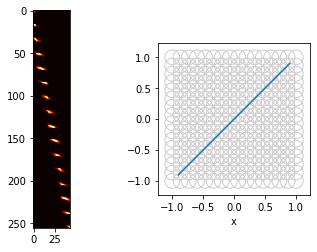

In [3]:
    # test load place cells and a trajectory
    pcs = load_place_cells('input/placecells.csv')
    abcde = load_path('input/abcde.csv')
    feeders = load_feeders('input/feeders.csv')

    # test load generator and generate path using 'sample_path_generator.csv':
    # the generator is a sequence of way points
    # 'steps' indicate the number of steps to reach the next way point
    # note: the number of steps in the last row is ignored
    #   x     |  y     | steps
    # ------------------------
    #   -0.4  |  -0.4  |   7
    #    0    |   0    |  10
    #    0.5  |   0    |  -1

    # note: alternatively you can generate the data like this:
    # sample_generator = pd.DataFrame({'x':     [-0.4,  0,  0.5],
    #                                  'y':     [-0.4,  0,  0  ],
    #                                  'steps': [ 7  , 10, -1  ]})
    
    #modifying to allow two sequences
#    sample_generator = load_generator('input/sample_path_generator.csv')
#    sample_generator2 = load_generator('input/sample_path_generator2.csv')
    sample_generator = load_generator('input/syn-fs-fs-fs')
    sample_generator2 = load_generator('input/syn-sf-sf-fs')
    sample_generator3 = load_generator('input/syn-mm-mm-mm')
    generated_path = generate_path(sample_generator)
    generated_path2 = generate_path(sample_generator2)
    generated_path3 = generate_path(sample_generator3)

    # test calculation of activation matrix
    # choose sequence: 'generated_path' or 'abcde'
    sequence = generated_path
    activations = calc_activation_matrix(sequence, pcs)
    sequence2 = generated_path2
    activations2 = calc_activation_matrix(sequence2, pcs)
    sequence3 = generated_path3
    activations3 = calc_activation_matrix(sequence3, pcs)    

    # test plot utilities
    fig, axs = plt.subplots(1, 2 )
    f1 = axs[0]
    f2 = axs[1]
    f2.autoscale(enable=True)
    f2.set_aspect('equal')
    plot_activation_matrix_heatmap(activations, plot=f1)

    plot_place_cells(pcs, plot=f2)  # add place cells to figure
#    plot_maze(plot=f2)
    plot_path(sequence, plot=f2)
#    plot_feeders(feeders, plot=f2, s=80, zorder=2)  # zorder can be used to move the layer up or down
    # plt.savefig('reservoirstates-Y-left.png', dpi = 1200)
    plt.show()



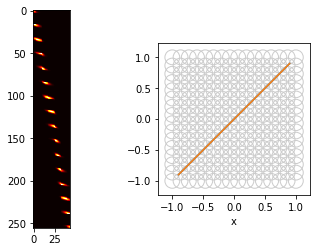

In [4]:
    # test plot utilities
    fig, axs = plt.subplots(1, 2 )
    f1 = axs[0]
    f2 = axs[1]
    f2.autoscale(enable=True)
    f2.set_aspect('equal')
    plot_activation_matrix_heatmap(activations2, plot=f1)

    plot_place_cells(pcs, plot=f2)  # add place cells to figure
#    plot_maze(plot=f2)
    plot_path(sequence, plot=f2)
    plot_path(sequence2, plot=f2)
#    plot_feeders(feeders, plot=f2, s=80, zorder=2)  # zorder can be used to move the layer up or down

    #plt.savefig('reservoirstates-Y-right.png')
    plt.show()



In [5]:
np.random.seed(1)
vectorDim = 256
numNode = 256
print(activations.shape)
inputDataTraining = activations.T
outputDataTraining = activations.T
print(inputDataTraining.shape)

(256, 43)
(43, 256)


In [6]:
for num in range(10):
    inputDataTraining = np.append(inputDataTraining, inputDataTraining, axis=0)
print(inputDataTraining.shape)
outputDataTraining=inputDataTraining

(44032, 256)


In [7]:
esn = PredictionESN(n_input=vectorDim, n_output=vectorDim, n_reservoir=numNode, leakingRate=0.05, regressionParameters=[1e-2], solver="lsqr", feedback=False)

In [8]:
esn.fit(inputDataTraining, outputDataTraining, transientTime="Auto", verbose=1)

100% (43488 of 43488) |##################| Elapsed Time: 0:00:08 Time:  0:00:08


1.9718515827207134e-05

In [9]:
print(PC_VALUE_AT_RADIUS)

0.6


In [10]:
inputDataTesting = activations.T
inputDataTesting2 = activations2.T
inputDataTesting3 = activations3.T
print(len(inputDataTesting))
print(len(inputDataTesting2))
print(len(inputDataTesting3))

43
43
43


In [12]:
reservoirStatesBuffer = np.empty((0,numNode))
prediction,reservoirStatesBuffer  = esn.predict(inputDataTesting)
reservoirStatesBuffer = reservoirStatesBuffer.T
reservoirStatesBuffer = reservoirStatesBuffer[:,257:]
print(reservoirStatesBuffer.shape)
print(prediction.shape)

(43, 256)
(43, 256)


In [13]:
reservoirStatesBuffer2 = np.empty((0,numNode))
prediction,reservoirStatesBuffer2  = esn.predict(inputDataTesting2)
reservoirStatesBuffer2 = reservoirStatesBuffer2.T
reservoirStatesBuffer2 = reservoirStatesBuffer2[:,257:]
print(reservoirStatesBuffer2.shape)
print(prediction.shape)

(43, 256)
(43, 256)


In [14]:
reservoirStatesBuffer3 = np.empty((0,numNode))
prediction,reservoirStatesBuffer3  = esn.predict(inputDataTesting3)
reservoirStatesBuffer3 = reservoirStatesBuffer3.T
reservoirStatesBuffer3 = reservoirStatesBuffer3[:,257:]
print(reservoirStatesBuffer3.shape)
print(prediction.shape)

(43, 256)
(43, 256)


In [15]:
# .95 .05
# .8  .2
vectordim=256
past = .95
present = 1.05

inputAverageTesting1 = np.zeros((len(inputDataTesting),vectorDim))
inputAverageTesting2 = np.zeros((len(inputDataTesting2),vectorDim))
inputAverageTesting3 = np.zeros((len(inputDataTesting3),vectorDim))

print(inputAverageTesting1.shape)

for num in range(len(inputDataTesting)):
        if num == 0:
            inputAverageTesting1[num] = inputDataTesting[num]
            inputAverageTesting2[num] = inputDataTesting2[num]
            inputAverageTesting3[num] = inputDataTesting3[num]
        else:
            inputAverageTesting1[num] = past*inputAverageTesting1[num-1] + present*inputDataTesting[num] 
            inputAverageTesting2[num] = past*inputAverageTesting2[num-1] + present*inputDataTesting2[num] 
            inputAverageTesting3[num] = past*inputAverageTesting3[num-1] + present*inputDataTesting3[num] 


(43, 256)


In [24]:
# with open('test.npy', 'wb') as f:
#     np.save(f,activa)
# display(activations.shape)
# display(activations[:,0])

# display(generated_path)

display(pcs)











,tgroup,subject,cellNum,x,y,placeradius
0,Control,1,0,-1.0,-1.000000,0.12
1,Control,1,1,-1.0,-0.866667,0.12
2,Control,1,2,-1.0,-0.733333,0.12
3,Control,1,3,-1.0,-0.600000,0.12
4,Control,1,4,-1.0,-0.466667,0.12
...,...,...,...,...,...,...
251,Control,1,251,1.0,0.466667,0.12
252,Control,1,252,1.0,0.600000,0.12
253,Control,1,253,1.0,0.733333,0.12
254,Control,1,254,1.0,0.866667,0.12


In [15]:

data = np.empty((len(inputDataTesting)))
data2 = np.empty((len(inputDataTesting)))

# simplify - dont need the whole trajectory, just for the final 
def cos_sim(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

for num in range(len(inputDataTesting)):
    data[num] = cos_sim(reservoirStatesBuffer[num],reservoirStatesBuffer2[num])
    #data2[num] = np.power(cos_sim(inputDataTestingA[num],inputDataTestingB[num]),3)
    data2[num] = cos_sim(inputDataTesting[num],inputDataTesting2[num])

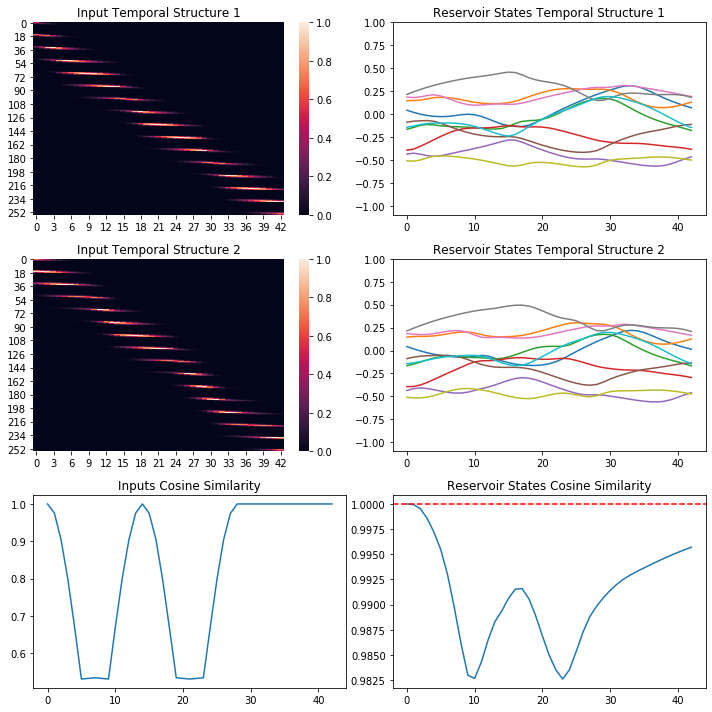

In [16]:
resn = 10
fig= plt.figure(figsize=(10,10))
#fig.suptitle('State Trajectories', fontsize=16)
#fig.suptitle('State Trajectories')

plt.subplot(321)

#plt.plot( inputDataTesting[:76,:])
#sns.heatmap(activations, cmap="seismic")
sns.heatmap(activations)

#plt.ylim([-1.1,1])
plt.title('Input Temporal Structure 1')

plt.subplot(323)

#plt.plot( inputDataTesting2[:76,:])
#sns.heatmap(activations2, vmin=0.4, vmax=1)
sns.heatmap(activations2)


#plt.ylim([-1.1,1])
plt.title('Input Temporal Structure 2')

plt.subplot(325)
plt.plot( data2)
#plt.ylim([-0.1,0.1])
plt.title('Inputs Cosine Similarity')

plt.subplot(322)
plt.plot( reservoirStatesBuffer[:,:resn])
#plt.plot( inputDataTestingA[:,:5])

plt.ylim([-1.1,1])
plt.title('Reservoir States Temporal Structure 1')

plt.subplot(324)
plt.plot( reservoirStatesBuffer2[:,:resn])
#plt.plot( inputDataTestingB[:,:5])


plt.ylim([-1.1,1])
plt.title('Reservoir States Temporal Structure 2')

plt.subplot(326)
plt.plot( data)
#plt.ylim([-0.1,0.1])
plt.title('Reservoir States Cosine Similarity')
plt.axhline(y=1, color='r', linestyle='--')


fig.tight_layout()

plt.savefig('reservoir-mixedsel.png')

In [17]:
print(data)

[1.         0.99993804 0.99951794 0.99854554 0.99718506 0.995471
 0.9929779  0.98969516 0.98610999 0.98298802 0.98267488 0.98431231
 0.98652337 0.98832116 0.98937333 0.99061803 0.99153566 0.99159486
 0.99059515 0.98891442 0.9868957  0.98499238 0.983513   0.98260899
 0.98353813 0.98535847 0.98727436 0.98880685 0.98983115 0.99068518
 0.99140827 0.99202749 0.99254046 0.9929498  0.99331102 0.99364601
 0.99397197 0.99429391 0.99460679 0.99490447 0.99518644 0.99545412
 0.99570636]


In [18]:
#here we replace reservoir with integrator
data = np.empty((len(inputDataTesting)))
data2 = np.empty((len(inputDataTesting)))

# simplify - dont need the whole trajectory, just for the final 
def cos_sim(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

for num in range(len(inputDataTesting)):
    data[num] = cos_sim(inputAverageTesting1[num],inputAverageTesting2[num])
    #data2[num] = np.power(cos_sim(inputDataTestingA[num],inputDataTestingB[num]),3)
    data2[num] = cos_sim(inputDataTesting[num],inputDataTesting2[num])

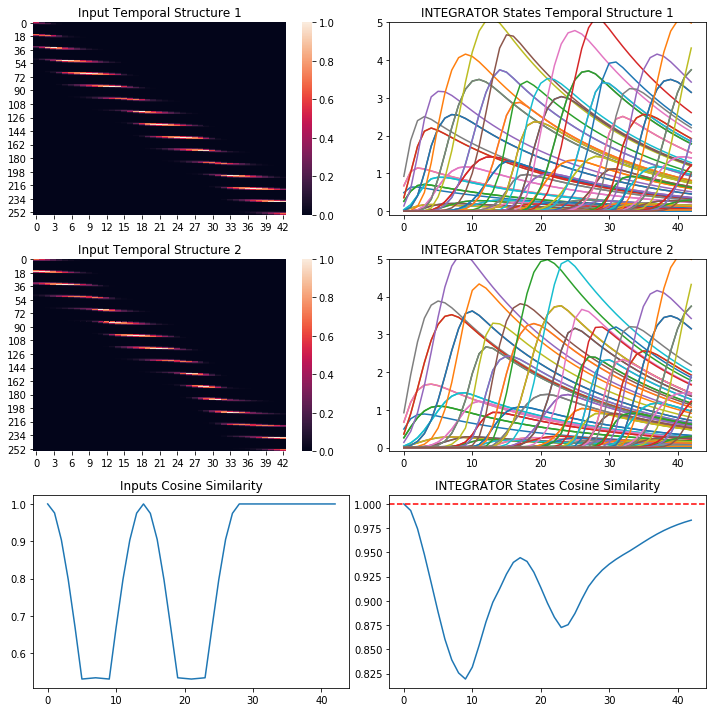

In [19]:
resn = 256
fig= plt.figure(figsize=(10,10))
#fig.suptitle('State Trajectories', fontsize=16)
#fig.suptitle('State Trajectories')

plt.subplot(321)

#plt.plot( inputDataTesting[:76,:])
#sns.heatmap(activations, cmap="seismic")
sns.heatmap(activations)

#plt.ylim([-1.1,1])
plt.title('Input Temporal Structure 1')

plt.subplot(323)

#plt.plot( inputDataTesting2[:76,:])
#sns.heatmap(activations2, vmin=0.4, vmax=1)
sns.heatmap(activations2)


#plt.ylim([-1.1,1])
plt.title('Input Temporal Structure 2')

plt.subplot(325)
plt.plot( data2)
#plt.ylim([-0.1,0.1])
plt.title('Inputs Cosine Similarity')

plt.subplot(322)
plt.plot( inputAverageTesting1[:,:resn])
#plt.plot( inputDataTestingA[:,:5])

plt.ylim([-0.1,5])
plt.title('INTEGRATOR States Temporal Structure 1')

plt.subplot(324)
plt.plot( inputAverageTesting2[:,:resn])
#plt.plot( inputDataTestingB[:,:5])


plt.ylim([-0.1,5])
plt.title('INTEGRATOR States Temporal Structure 2')

plt.subplot(326)
plt.plot( data)
#plt.ylim([-0.1,0.1])
plt.axhline(y=1, color='r', linestyle='--')

plt.title('INTEGRATOR States Cosine Similarity')

fig.tight_layout()

plt.savefig('li-mixedsel.png')

In [20]:
print(data)

[1.         0.99321914 0.97439661 0.94788282 0.91852646 0.88859088
 0.86057526 0.83921269 0.82572161 0.81942544 0.83167417 0.85417958
 0.87831174 0.89856608 0.91255146 0.92767604 0.9397344  0.94459183
 0.94071144 0.9295839  0.91403914 0.89758164 0.88313369 0.87258985
 0.87546772 0.88704563 0.90172529 0.91496793 0.92429486 0.93181764
 0.93783075 0.94287462 0.94735808 0.95149497 0.95595876 0.96049519
 0.9648755  0.96894089 0.97260407 0.97584022 0.97867049 0.98113527
 0.98327189]


In [21]:
stat_data=np.zeros((numNode,18))

In [22]:
print(len(reservoirStatesBuffer2[1]))

256


In [23]:
#OK NOW WE FORMAT THE DATA TO GO INTO THE ANOVA
# 8 6 8
# 4 11 18
#6 8 8
#3 10 18
# 7 7 8
# 
#create stats table: three columns
early = 13#4#5#8 #7
middle = 27#11#11#13#15
late = 41#18#16#15
delta=1
for i in range(len(reservoirStatesBuffer2[1])):
    #12 columns: 2x2x3 type, rep, 5, 13, 21 for 'fss_0', 'fss_1', 'sfs_0', 'sfs_1'
    stat_data[i,0]=reservoirStatesBuffer[early,i]
    stat_data[i,1]=reservoirStatesBuffer[middle,i]    
    stat_data[i,2]=reservoirStatesBuffer[late,i]        
    stat_data[i,3]=reservoirStatesBuffer[early+delta,i]
    stat_data[i,4]=reservoirStatesBuffer[middle+delta,i]    
    stat_data[i,5]=reservoirStatesBuffer[late+delta,i]            

    stat_data[i,6]=reservoirStatesBuffer2[early,i]
    stat_data[i,7]=reservoirStatesBuffer2[middle,i]    
    stat_data[i,8]=reservoirStatesBuffer2[late,i]        
    stat_data[i,9]=reservoirStatesBuffer2[early+delta,i]
    stat_data[i,10]=reservoirStatesBuffer2[middle+delta,i]    
    stat_data[i,11]=reservoirStatesBuffer2[late+delta,i]      
    
    stat_data[i,12]=reservoirStatesBuffer3[early,i]
    stat_data[i,13]=reservoirStatesBuffer3[middle,i]    
    stat_data[i,14]=reservoirStatesBuffer3[late,i]        
    stat_data[i,15]=reservoirStatesBuffer3[early+delta,i]
    stat_data[i,16]=reservoirStatesBuffer3[middle+delta,i]    
    stat_data[i,17]=reservoirStatesBuffer3[late+delta,i]          

In [24]:
import pandas as pd
import numpy as np
# load data file
df=pd.read_excel("test-data-template-3seq.xlsx")
print(df)

   subject position sequence   valye speed
0       s1      ear      fss  0.3599  fast
1       s1      mid      fss  0.3975  slow
2       s1     late      fss  0.3278  slow
3       s2      ear      fss  0.2908  fast
4       s2      mid      fss  0.2844  slow
5       s2     late      fss  0.2907  slow
6       s1      ear      sfs  0.3724  slow
7       s1      mid      sfs  0.3582  fast
8       s1     late      sfs  0.2207  slow
9       s2      ear      sfs  0.2460  slow
10      s2      mid      sfs  0.3044  fast
11      s2     late      sfs  0.2779  slow
12      s1      ear      mmm  0.3724   med
13      s1      mid      mmm  0.3582   med
14      s1     late      mmm  0.2207   med
15      s2      ear      mmm  0.2460   med
16      s2      mid      mmm  0.3044   med
17      s2     late      mmm  0.2779   med


In [25]:
neuron = 50
for i in range(18):
    df.loc[i,'valye']=stat_data[neuron,i]

In [26]:
print(df)

   subject position sequence     valye speed
0       s1      ear      fss -0.086023  fast
1       s1      mid      fss -0.189607  slow
2       s1     late      fss  0.051913  slow
3       s2      ear      fss -0.067609  fast
4       s2      mid      fss -0.208923  slow
5       s2     late      fss  0.082798  slow
6       s1      ear      sfs -0.129028  slow
7       s1      mid      sfs -0.171699  fast
8       s1     late      sfs  0.070885  slow
9       s2      ear      sfs -0.110764  slow
10      s2      mid      sfs -0.191366  fast
11      s2     late      sfs  0.101592  slow
12      s1      ear      mmm -0.088369   med
13      s1      mid      mmm -0.165251   med
14      s1     late      mmm  0.022183   med
15      s2      ear      mmm -0.070105   med
16      s2      mid      mmm -0.185143   med
17      s2     late      mmm  0.054566   med


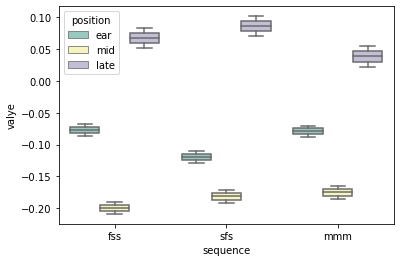

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.boxplot(hue="position", y="valye", x="sequence", data=df, palette="Set3")
plt.show()

In [28]:
import pingouin as pg
res = pg.anova(dv='valye', between=['position', 'sequence'], 
                  data=df, detailed=True)
res

C:\Users\PeterDell\anaconda3\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.


,Source,SS,DF,MS,F,p-unc,np2
0,position,0.190404,2,0.095202,335.522331,3.529172e-09,0.986766
1,sequence,0.000021,2,0.000011,0.037719,9.631345e-01,0.008312
2,position * sequence,0.005269,4,0.001317,4.642755,2.615011e-02,0.673570
3,Residual,0.002554,9,0.000284,NaN,NaN,NaN


In [29]:
res = pg.rm_anova(dv='valye', within=['position', 'speed'], subject='subject', 
                  data=df, detailed=True)
res

C:\Users\PeterDell\anaconda3\lib\site-packages\pingouin\distribution.py:459: UserWarning: Epsilon values might be innaccurate in two-way repeated measures design where each  factor has more than 2 levels. Please  double-check your results.


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,position,0.185001,2,2,0.092500,79.368756,0.012443,0.071161,0.987557,0.500000
1,speed,0.011718,2,2,0.005859,199.020900,0.004999,0.045051,0.995001,0.500000
2,position * speed,-0.050601,4,4,-0.012650,90.826722,0.000353,0.066556,0.989110,0.142857


111
121
121


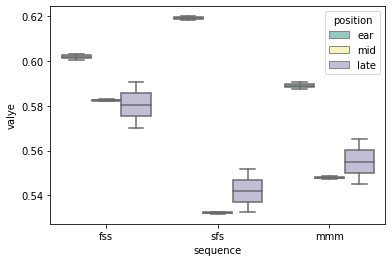

Shape changer:  25
121
122
121


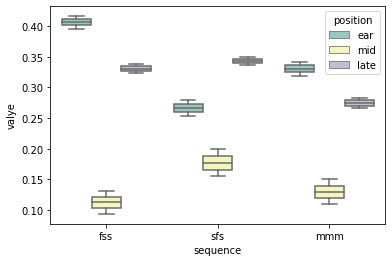

Shape changer:  27
211
212
212


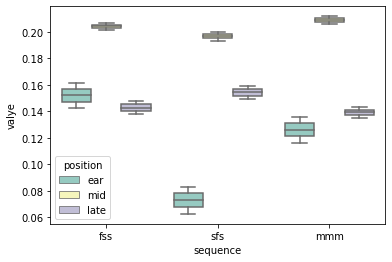

Shape changer:  44
122
121
122


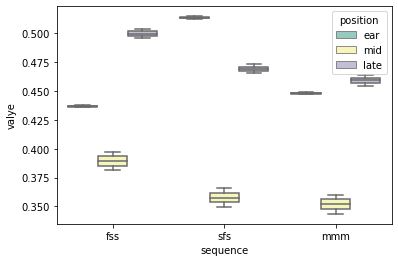

Shape changer:  52
111
211
211


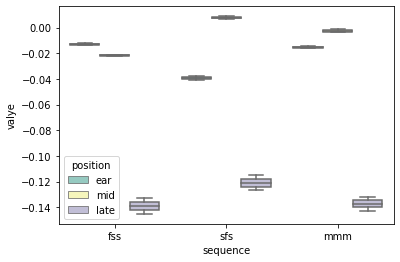

Shape changer:  53
211
212
211


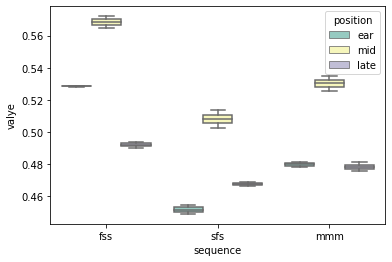

Shape changer:  55
122
222
222


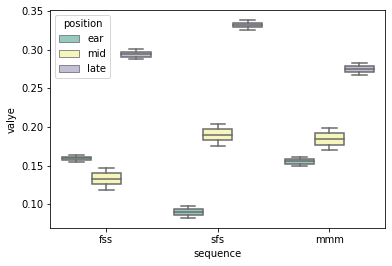

Shape changer:  71
111
211
111


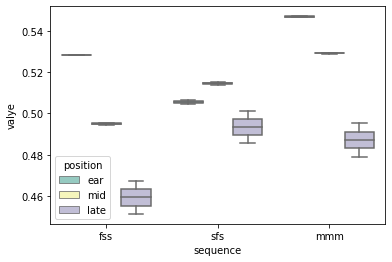

Shape changer:  72
121
122
122


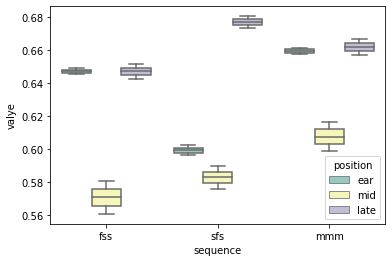

Shape changer:  82
122
222
222


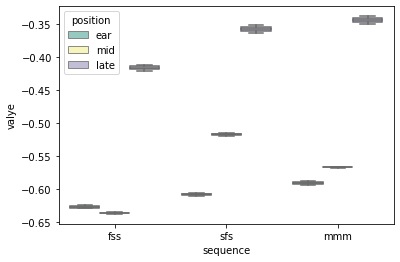

Shape changer:  83
111
211
111


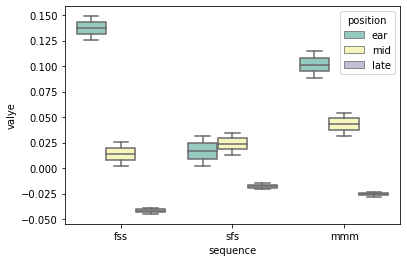

Shape changer:  88
222
122
122


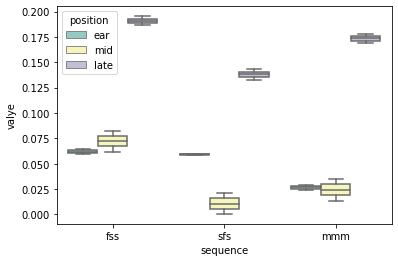

Shape changer:  90
211
212
211


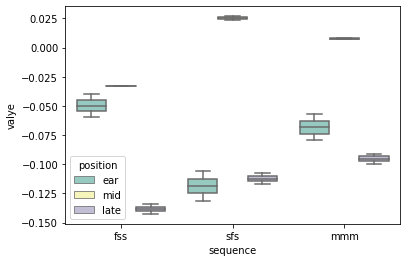

Shape changer:  96
121
111
111


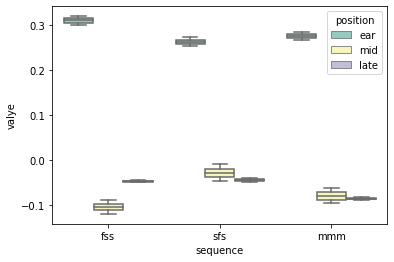

Shape changer:  97
122
222
111


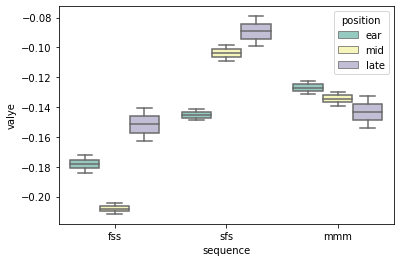

Shape changer:  105
121
122
121


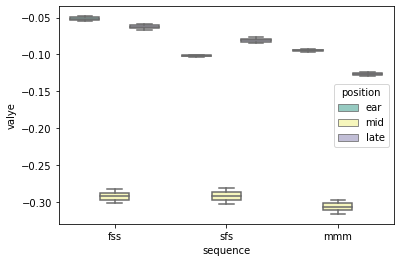

Shape changer:  116
121
122
122


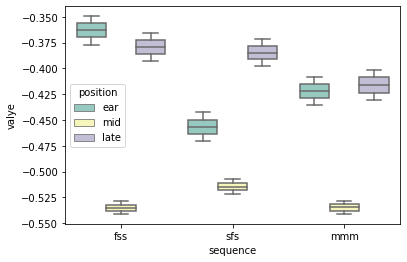

Shape changer:  118
111
211
111


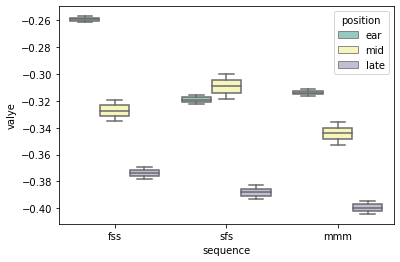

Shape changer:  121
222
212
212


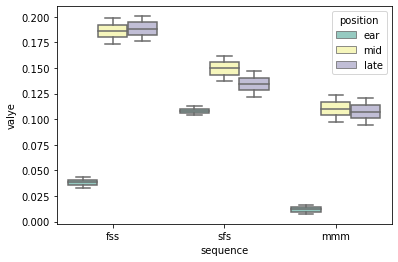

Shape changer:  124
122
222
122


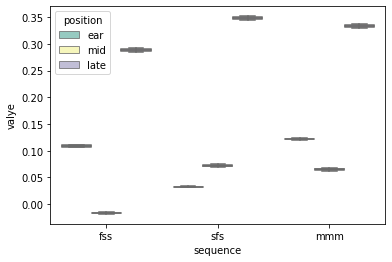

Shape changer:  127
122
222
222


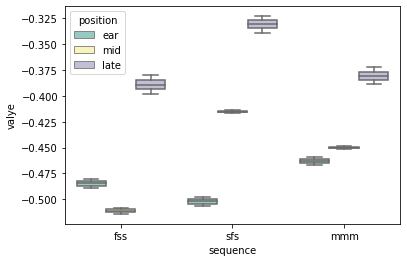

Shape changer:  130
212
222
212


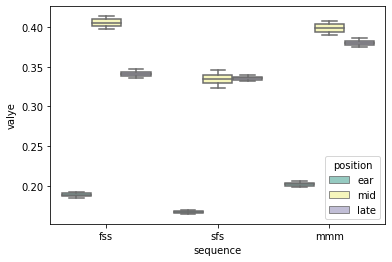

Shape changer:  133
121
122
121


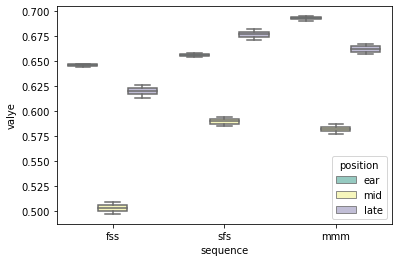

Shape changer:  140
122
121
122


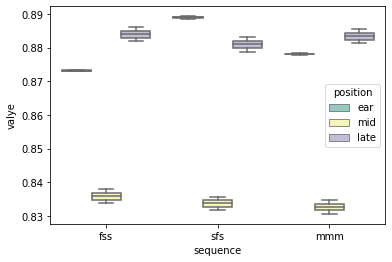

Shape changer:  142
211
212
212


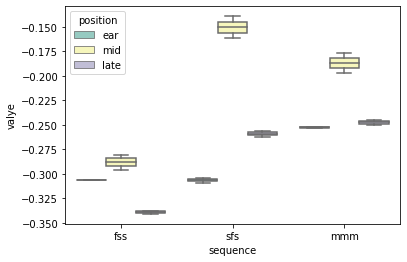

Shape changer:  146
212
211
212


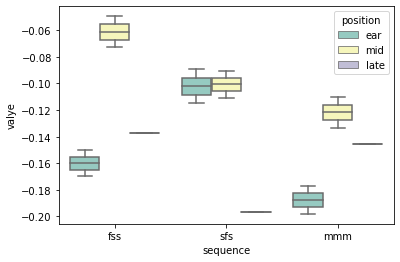

Shape changer:  156
111
121
111


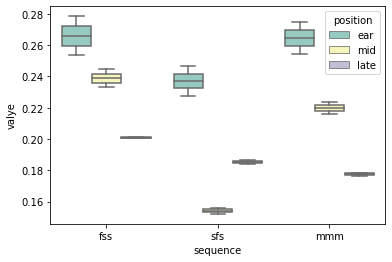

Shape changer:  163
122
222
211


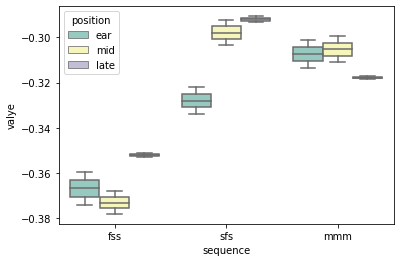

Shape changer:  166
122
212
211


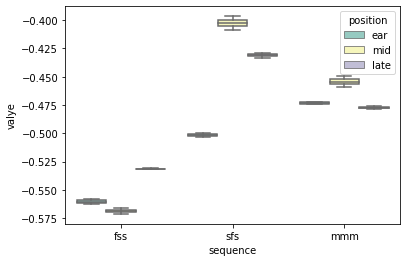

Shape changer:  167
222
122
122


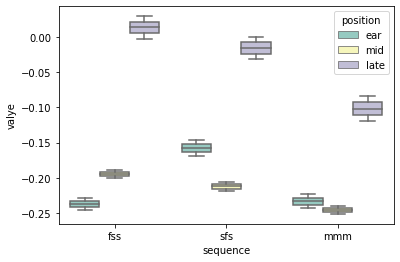

Shape changer:  170
111
212
211


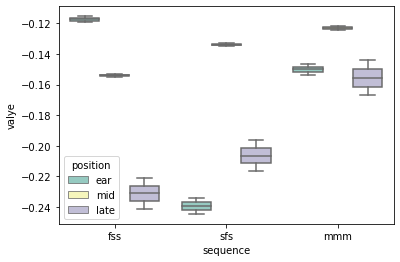

Shape changer:  173
222
122
222


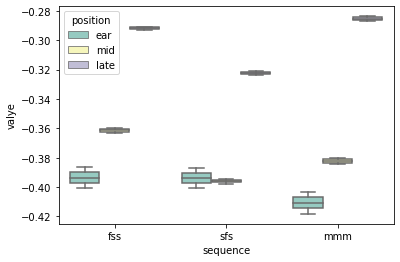

Shape changer:  175
222
121
122


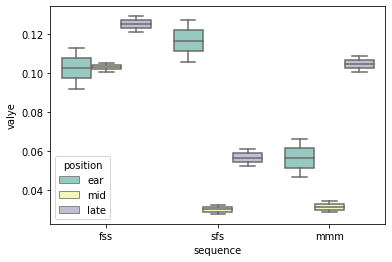

Shape changer:  183
122
121
121


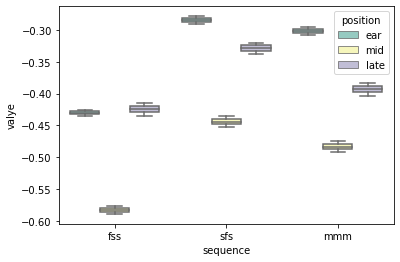

Shape changer:  190
111
211
211


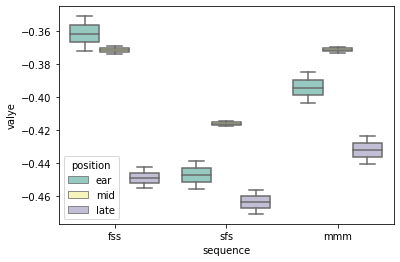

Shape changer:  191
211
212
212


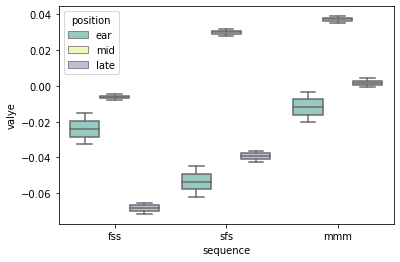

Shape changer:  192
212
121
222


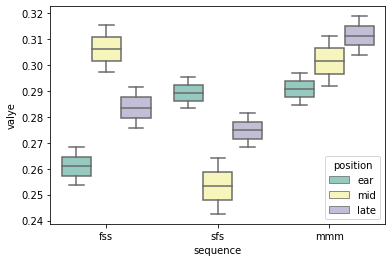

Shape changer:  193
121
122
121


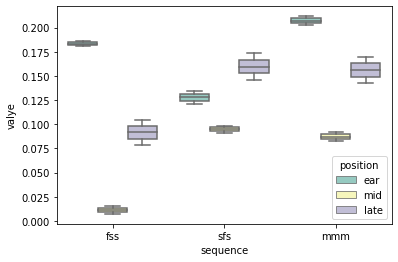

Shape changer:  194
212
211
212


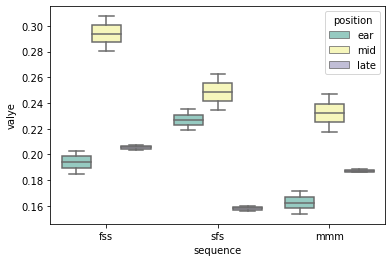

Shape changer:  199
211
111
212


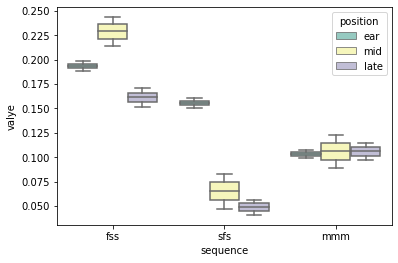

Shape changer:  205
111
211
121


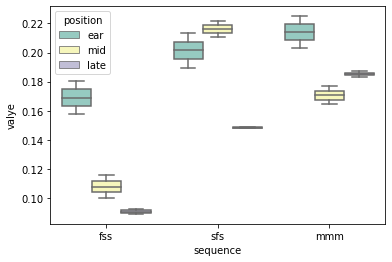

Shape changer:  206
121
222
121


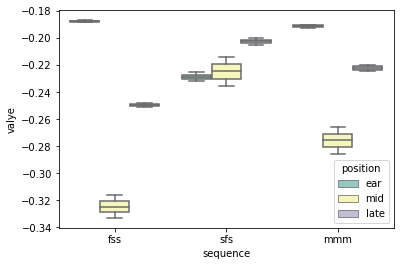

Shape changer:  211
222
121
222


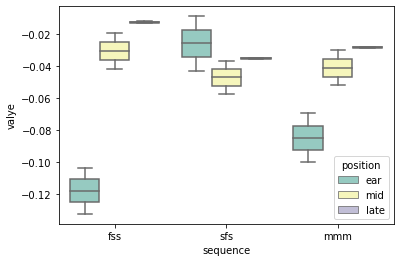

Shape changer:  231
222
212
222


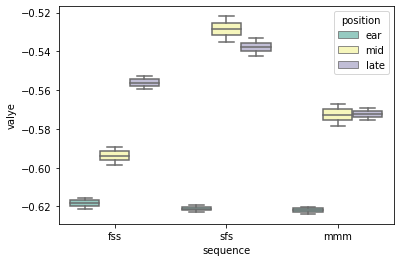

Shape changer:  233
111
212
222


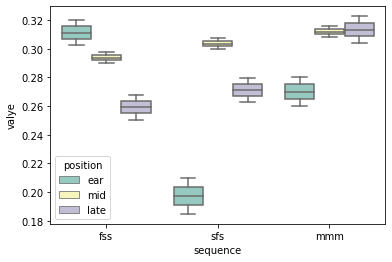

Shape changer:  235
212
211
212


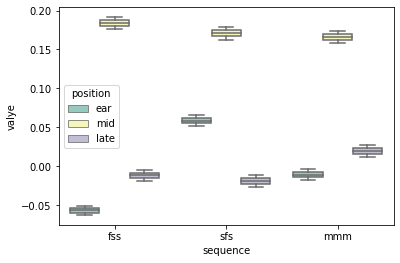

Shape changer:  237
121
212
121


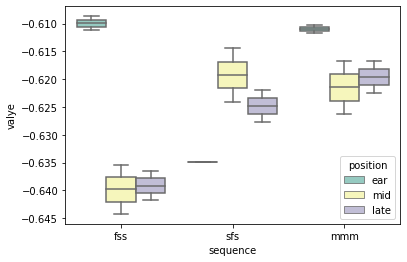

Shape changer:  253
121
111
121


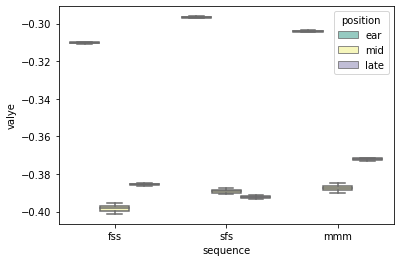

Shape changer:  255
p-unc 0.01
position effect    :  253
sequence effec    t:  188
pos*seq interaction:  122
shape changer      :  48


In [30]:
p_count=0
s_count=0
ps_count=0
sc_count=0
sign = 0.01
factor ='p-unc'#'p-GG-corr'#
for neuron in range(numNode):
    for i in range(18):
        df.loc[i,'valye']=stat_data[neuron,i]
    #print("Neuron", neuron)
        
#    res = pg.rm_anova(dv='valye', within=['position', 'sequence'], subject='subject', 
#                  data=df, detailed=True)
    res = pg.anova(dv='valye', between=['position', 'sequence'], 
                  data=df, detailed=True)
    if res.loc[0,factor] < sign:
        p_count = p_count +1

    if res.loc[1,factor] < sign:
        s_count = s_count +1

    if res.loc[2,factor] < sign:
        ps_count = ps_count +1  
        if is_shapechanger(df):
            sc_count = sc_count + 1
            sns.boxplot(hue="position", y="valye", x="sequence", data=df, palette="Set3")
            plt.show()
            print("Shape changer: ", neuron)

    #if res.loc[0,factor] < sign and res.loc[1,factor] < sign and np.mean(stat_data[neuron,:]) > 0:
        #print("Two way main effect neuron: ", neuron)
print(factor, sign)
print("position effect    : ",p_count)       
print("sequence effec    t: ",s_count)       
print("pos*seq interaction: ",ps_count)    
print("shape changer      : ",sc_count)

In [31]:
# p-unc 0.05
#position effect    :  390
#sequence effec    t:  223
#pos*seq interaction:  54

In [32]:
#now same thing for LI
stat_data_li=np.zeros((256,18))

In [33]:
#OK NOW WE FORMAT THE DATA TO GO INTO THE ANOVA
#inputAverageTesting1
# 8 6 8
#6 8 8
#create stats table: three columns
#early = 5#8 #7
#middle = 11#13#15
#late = 15#16#15

for i in range(len(inputAverageTesting2[1])):
    #12 columns: 2x2x3 type, rep, 5, 13, 21 for 'fss_0', 'fss_1', 'sfs_0', 'sfs_1'
    stat_data_li[i,0]=inputAverageTesting1[early,i]
    stat_data_li[i,1]=inputAverageTesting1[middle,i]    
    stat_data_li[i,2]=inputAverageTesting1[late,i]        
    stat_data_li[i,3]=inputAverageTesting1[early+delta,i]
    stat_data_li[i,4]=inputAverageTesting1[middle+delta,i]    
    stat_data_li[i,5]=inputAverageTesting1[late+delta,i]            

    stat_data_li[i,6]=inputAverageTesting2[early,i]
    stat_data_li[i,7]=inputAverageTesting2[middle,i]    
    stat_data_li[i,8]=inputAverageTesting2[late,i]        
    stat_data_li[i,9]=inputAverageTesting2[early+delta,i]
    stat_data_li[i,10]=inputAverageTesting2[middle+delta,i]    
    stat_data_li[i,11]=inputAverageTesting2[late+delta,i] 
    
    stat_data_li[i,12]=inputAverageTesting3[early,i]
    stat_data_li[i,13]=inputAverageTesting3[middle,i]    
    stat_data_li[i,14]=inputAverageTesting3[late,i]        
    stat_data_li[i,15]=inputAverageTesting3[early+delta,i]
    stat_data_li[i,16]=inputAverageTesting3[middle+delta,i]    
    stat_data_li[i,17]=inputAverageTesting3[late+delta,i]     

Mixed selectivity:  0


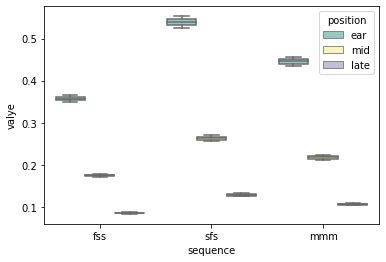

Mixed selectivity:  1


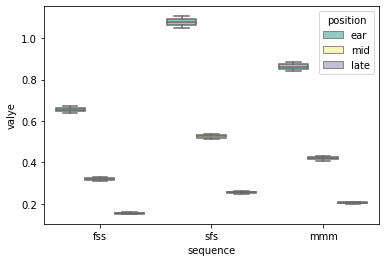

Mixed selectivity:  2


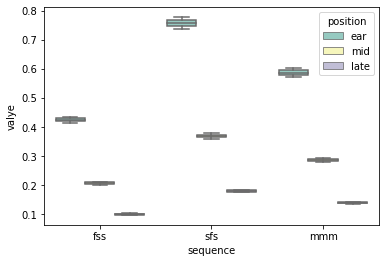

Mixed selectivity:  3


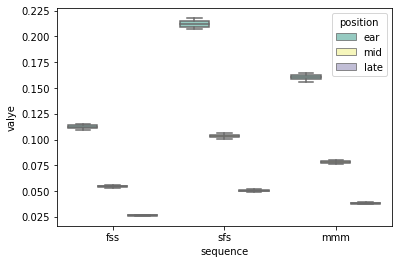

Mixed selectivity:  4


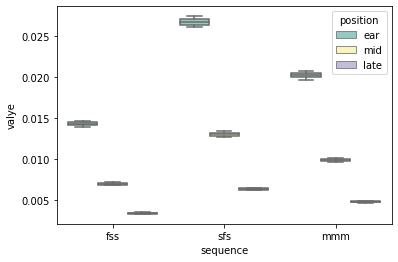

Mixed selectivity:  5


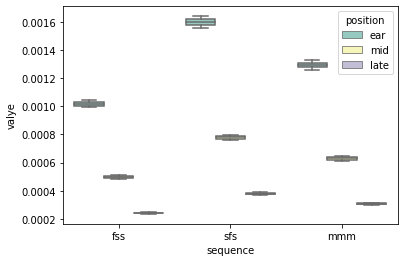

Mixed selectivity:  7


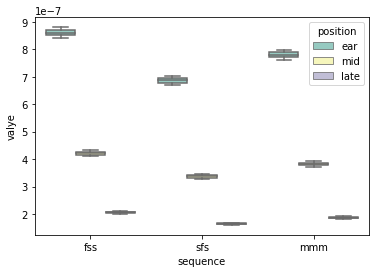

Mixed selectivity:  8


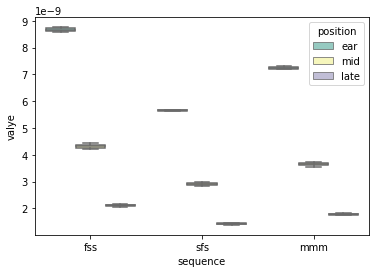

Mixed selectivity:  9


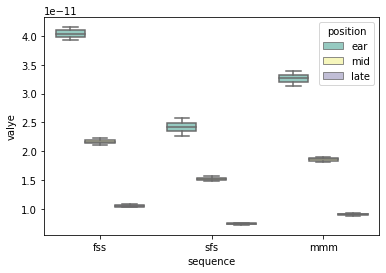

Mixed selectivity:  12


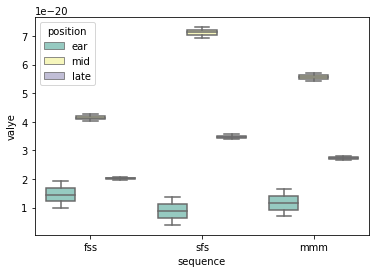

Mixed selectivity:  13


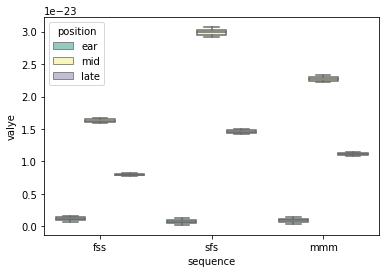

Mixed selectivity:  14


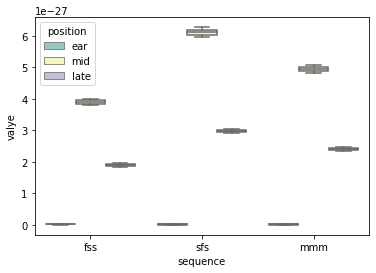

Mixed selectivity:  16


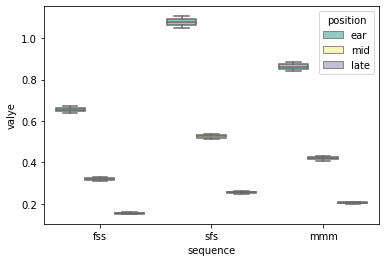

Mixed selectivity:  17


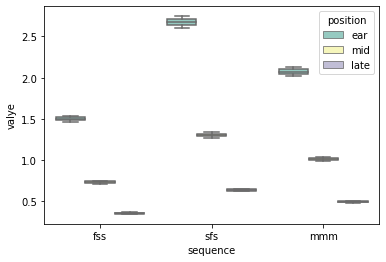

Mixed selectivity:  18


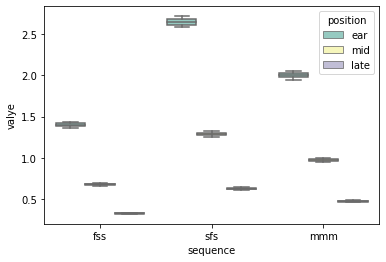

Mixed selectivity:  19


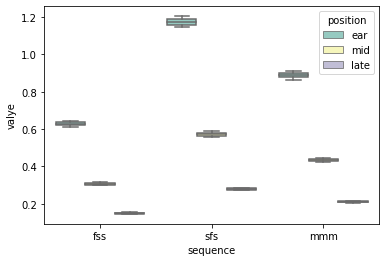

Mixed selectivity:  20


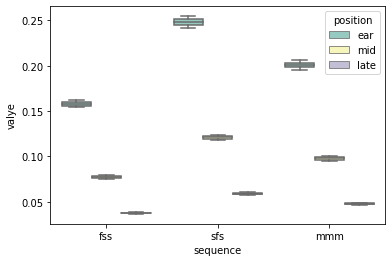

Mixed selectivity:  22


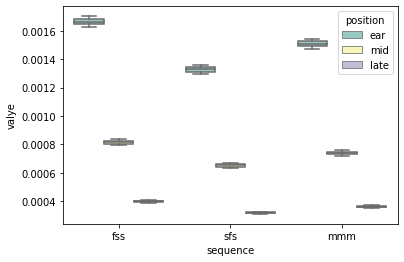

Mixed selectivity:  23


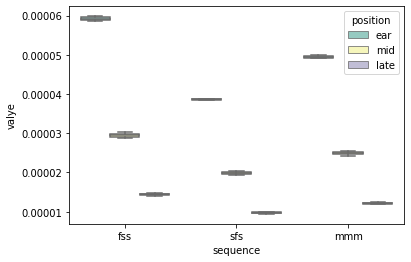

Mixed selectivity:  24


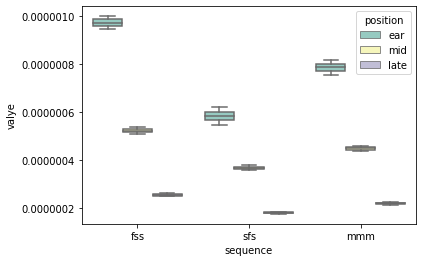

Mixed selectivity:  27


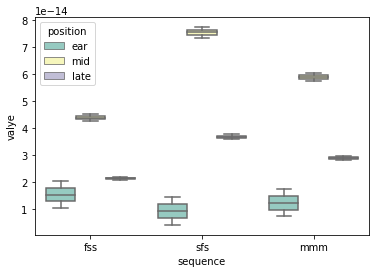

Mixed selectivity:  28


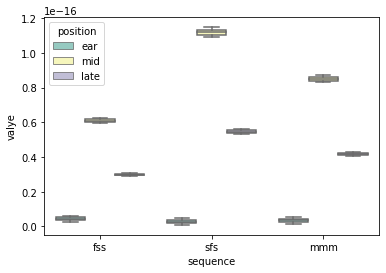

Mixed selectivity:  29


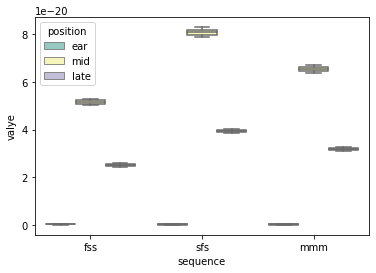

Mixed selectivity:  31


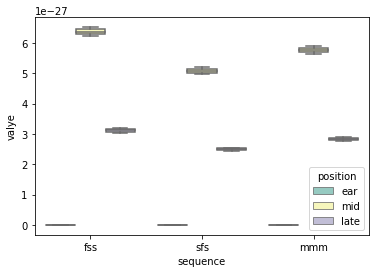

Mixed selectivity:  32


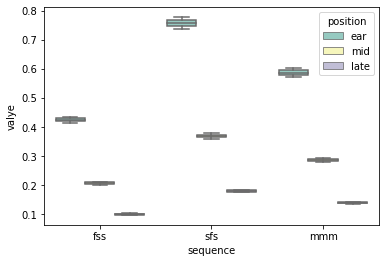

Mixed selectivity:  33


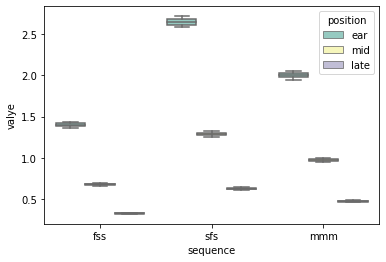

Mixed selectivity:  34


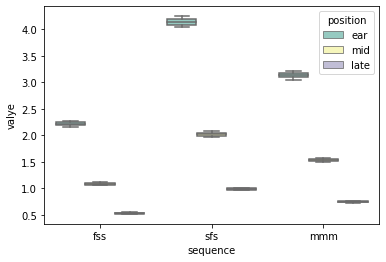

Mixed selectivity:  35


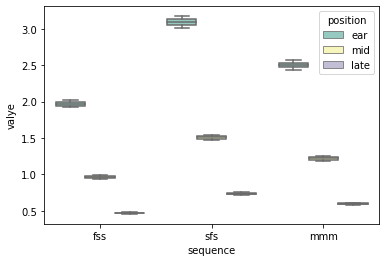

Mixed selectivity:  37


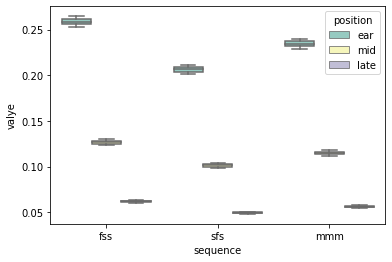

Mixed selectivity:  38


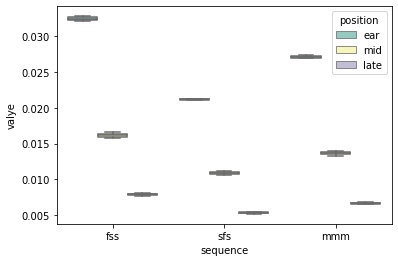

Mixed selectivity:  39


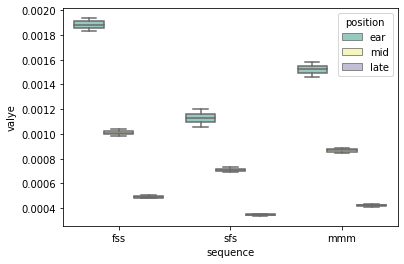

Mixed selectivity:  42


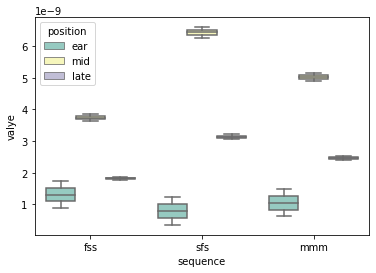

Mixed selectivity:  43


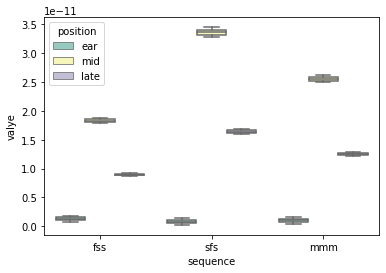

Mixed selectivity:  44


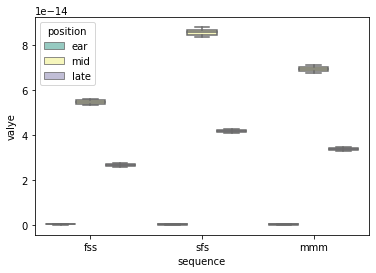

Mixed selectivity:  46


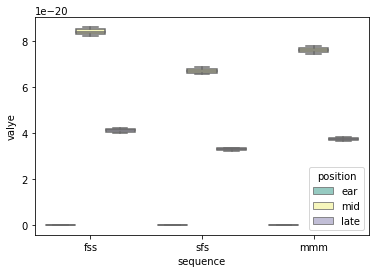

Mixed selectivity:  47


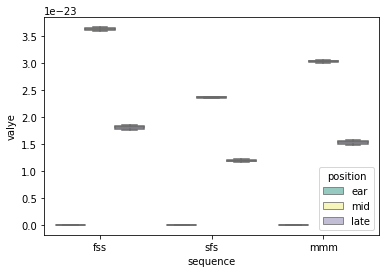

Mixed selectivity:  48


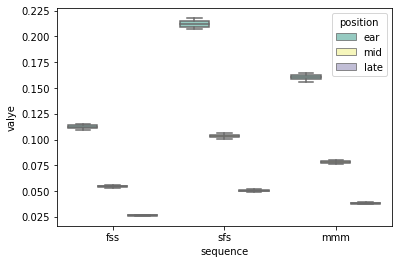

Mixed selectivity:  49


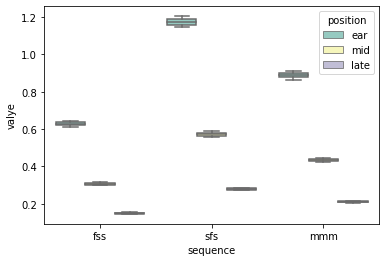

Mixed selectivity:  50


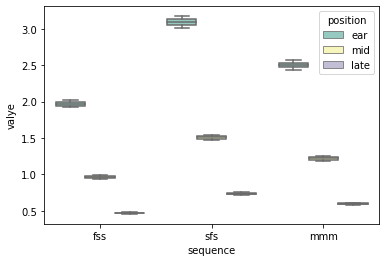

Mixed selectivity:  52


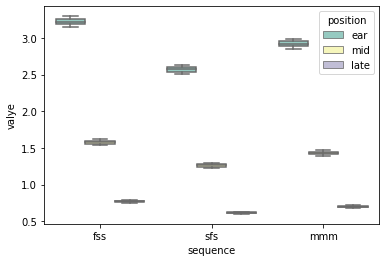

Mixed selectivity:  53


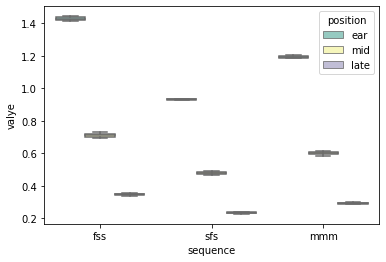

Mixed selectivity:  54


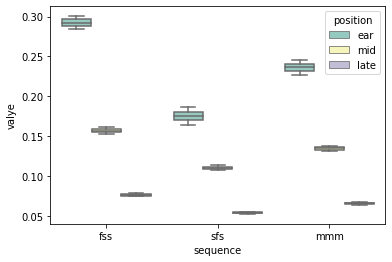

Mixed selectivity:  57


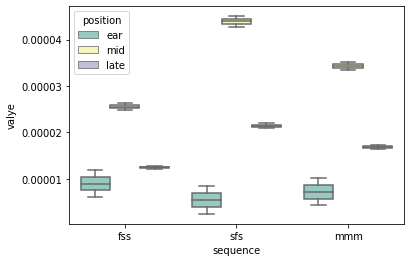

Mixed selectivity:  58


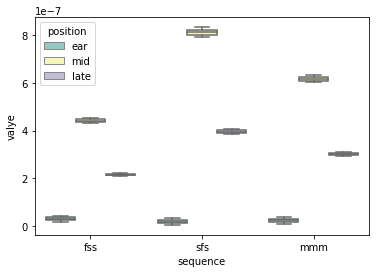

Mixed selectivity:  59


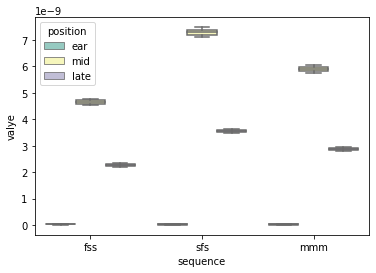

Mixed selectivity:  61


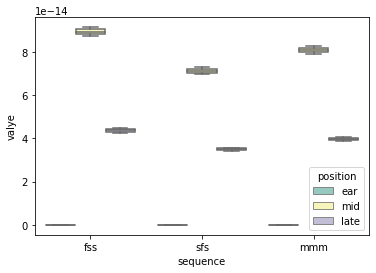

Mixed selectivity:  62


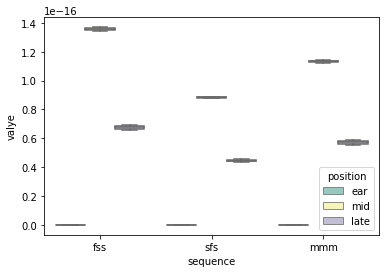

Mixed selectivity:  63


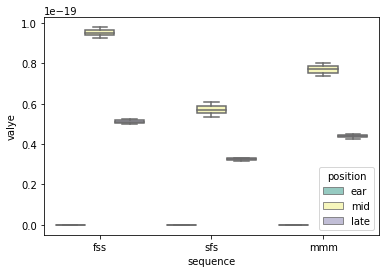

Mixed selectivity:  64


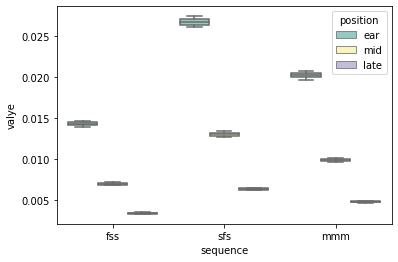

Mixed selectivity:  65


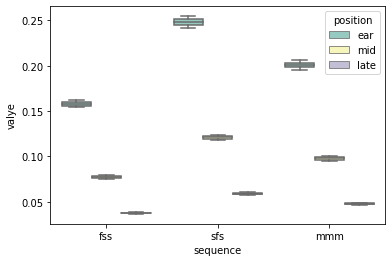

Mixed selectivity:  67


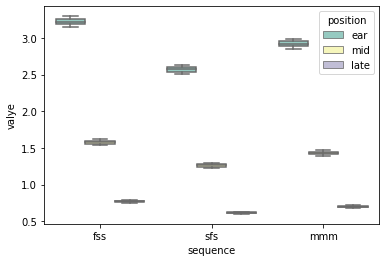

Mixed selectivity:  68


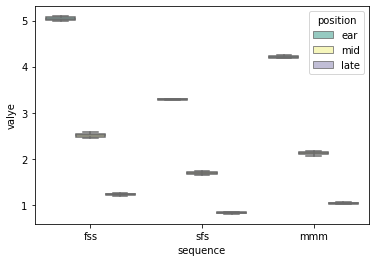

Mixed selectivity:  69


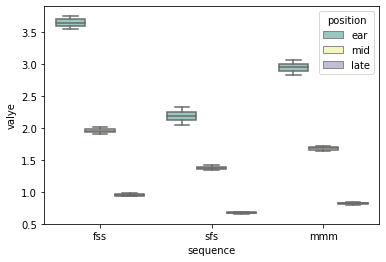

Mixed selectivity:  72


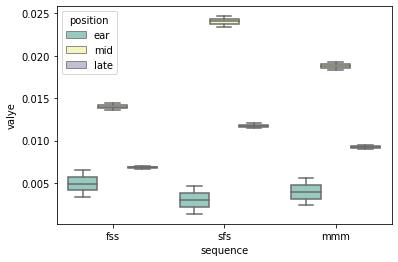

Mixed selectivity:  73


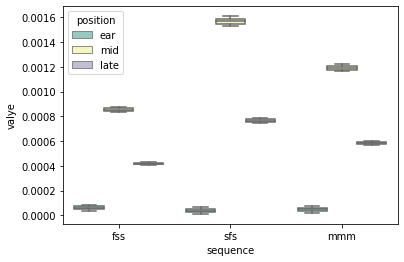

Mixed selectivity:  74


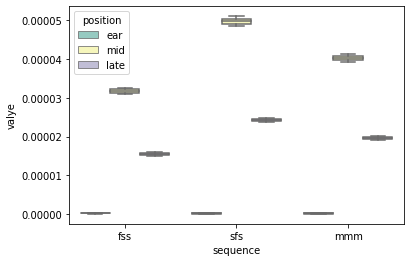

Mixed selectivity:  76


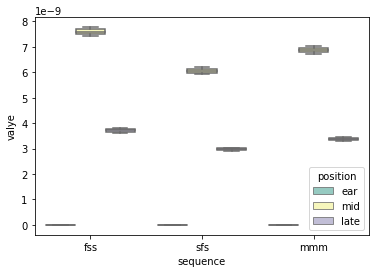

Mixed selectivity:  77


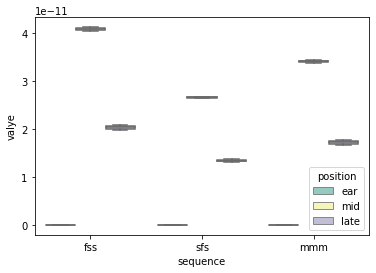

Mixed selectivity:  78


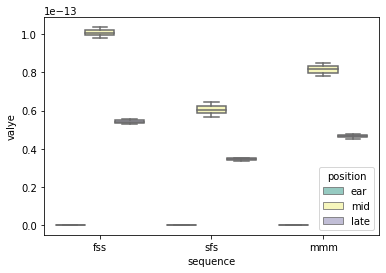

Mixed selectivity:  80


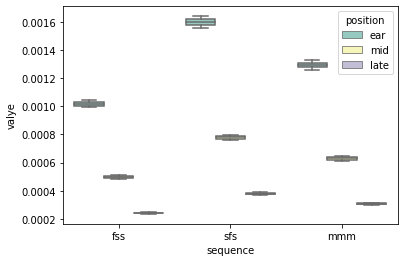

Mixed selectivity:  82


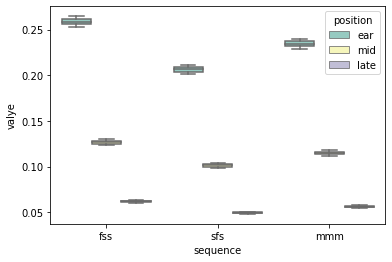

Mixed selectivity:  83


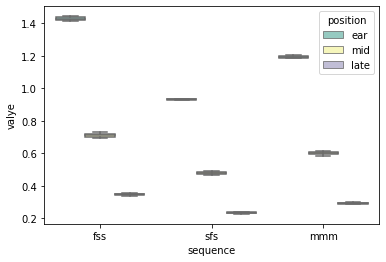

Mixed selectivity:  84


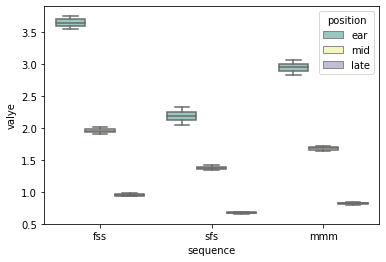

Mixed selectivity:  87


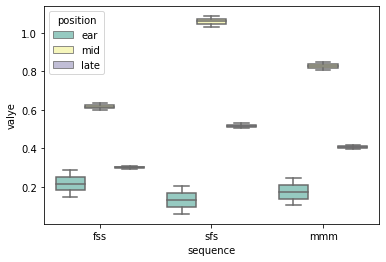

Mixed selectivity:  88


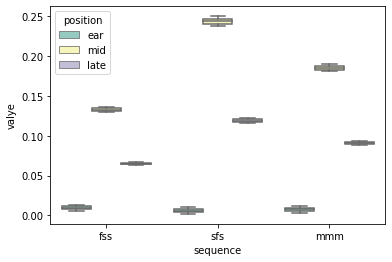

Mixed selectivity:  89


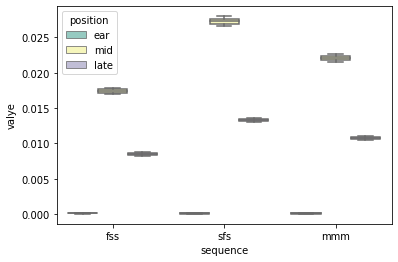

Mixed selectivity:  91


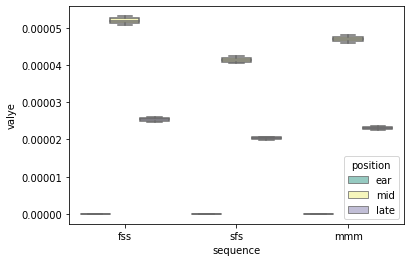

Mixed selectivity:  92


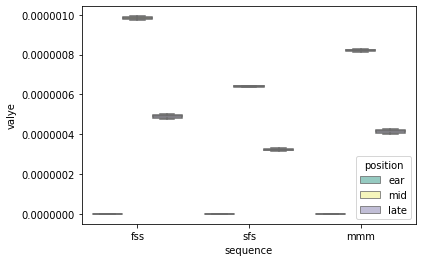

Mixed selectivity:  93


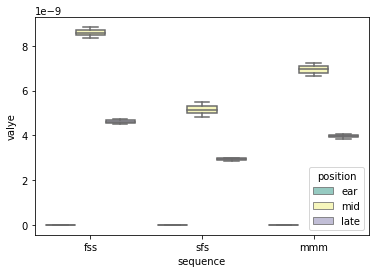

Mixed selectivity:  97


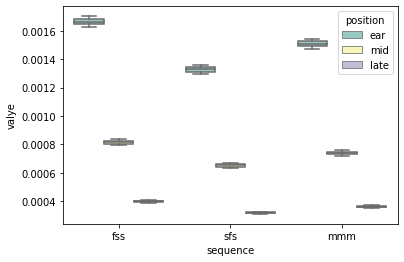

Mixed selectivity:  98


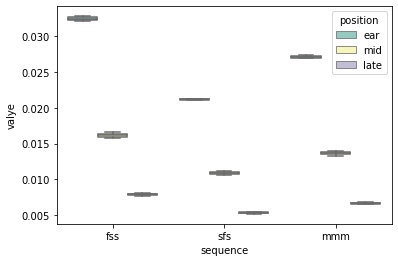

Mixed selectivity:  99


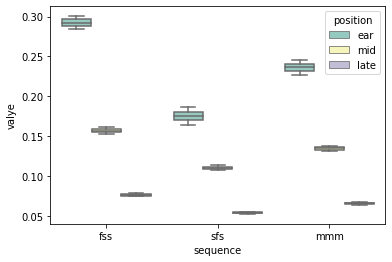

Mixed selectivity:  102


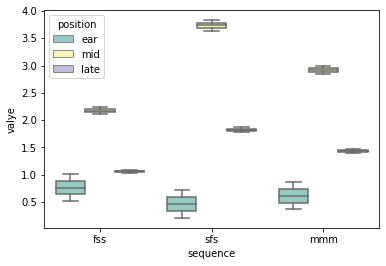

Mixed selectivity:  103


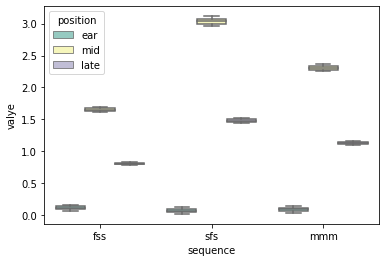

Mixed selectivity:  104


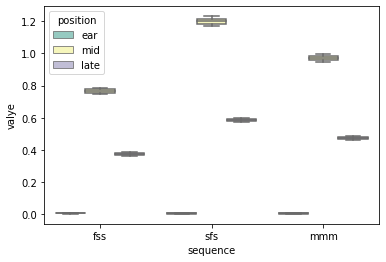

Mixed selectivity:  106


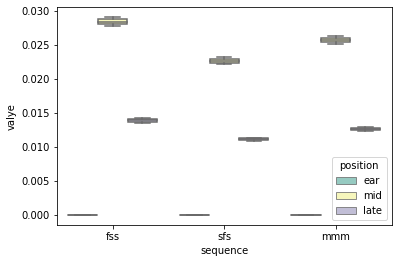

Mixed selectivity:  107


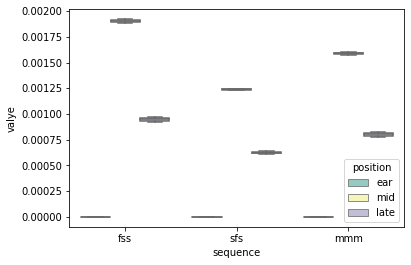

Mixed selectivity:  108


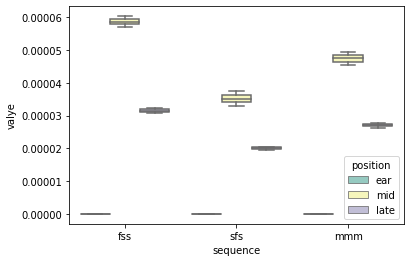

Mixed selectivity:  112


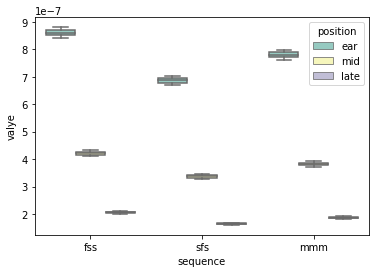

Mixed selectivity:  113


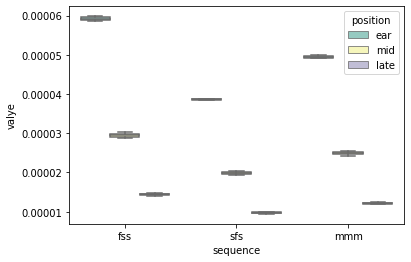

Mixed selectivity:  114


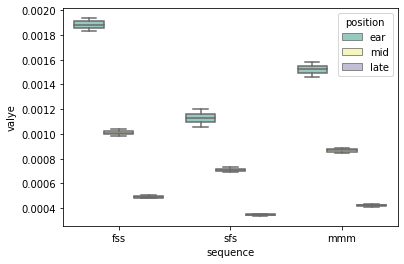

Mixed selectivity:  117


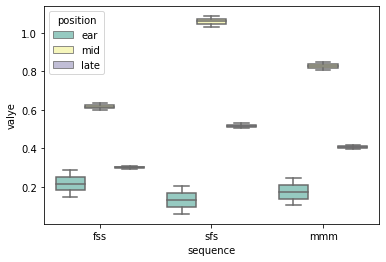

Mixed selectivity:  118


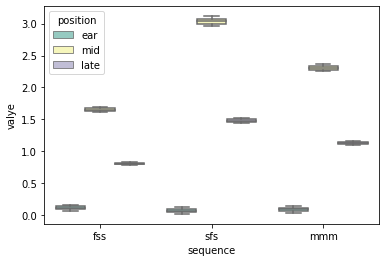

Mixed selectivity:  119


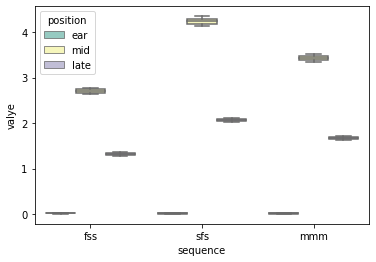

Mixed selectivity:  121


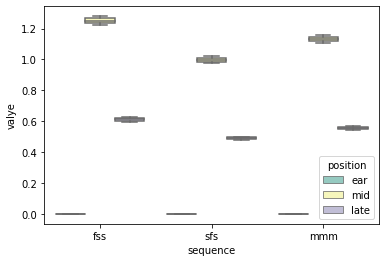

Mixed selectivity:  122


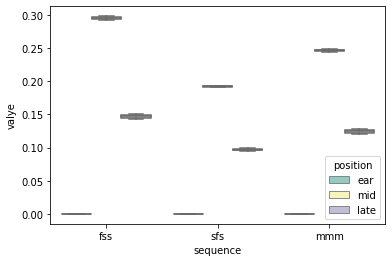

Mixed selectivity:  123


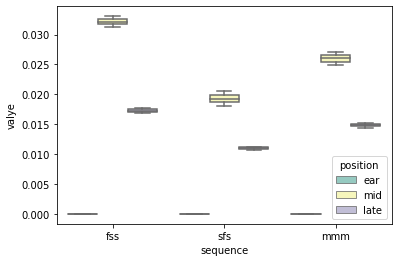

Mixed selectivity:  127


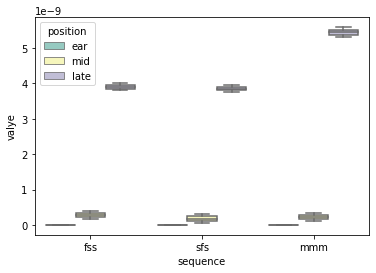

Mixed selectivity:  128


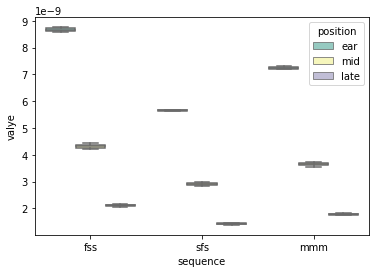

Mixed selectivity:  129


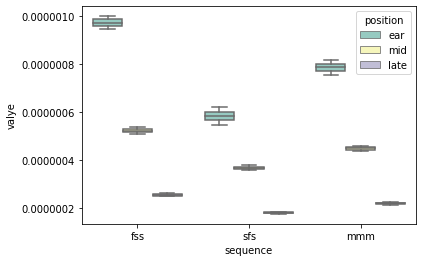

Mixed selectivity:  132


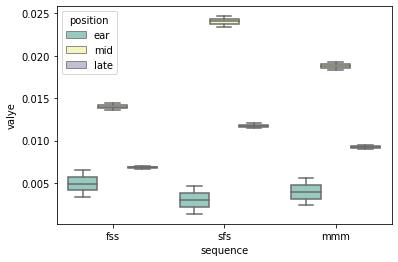

Mixed selectivity:  133


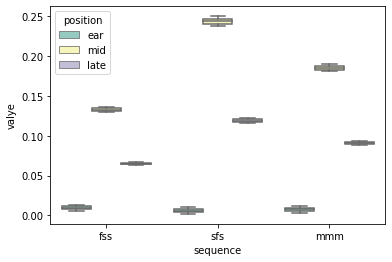

Mixed selectivity:  134


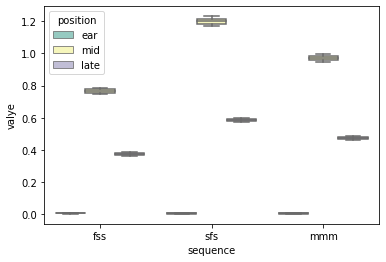

Mixed selectivity:  136


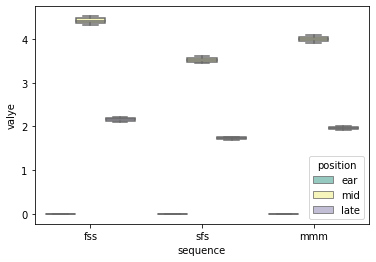

Mixed selectivity:  137


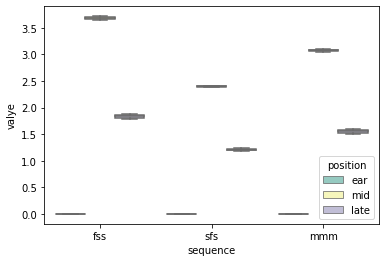

Mixed selectivity:  138


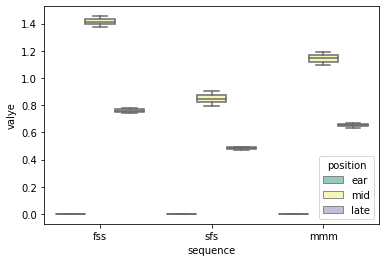

Mixed selectivity:  142


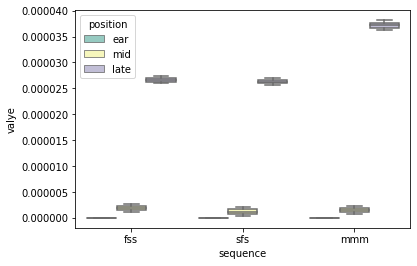

Mixed selectivity:  143


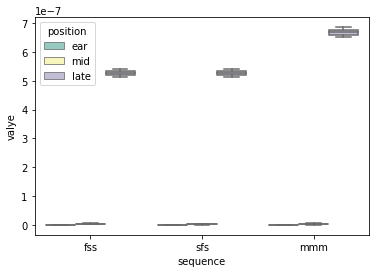

Mixed selectivity:  144


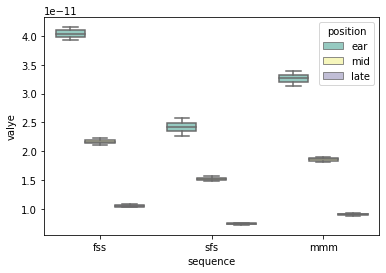

Mixed selectivity:  147


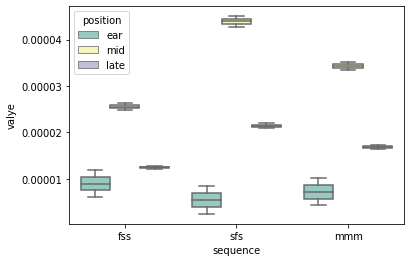

Mixed selectivity:  148


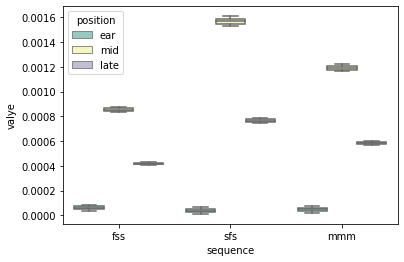

Mixed selectivity:  149


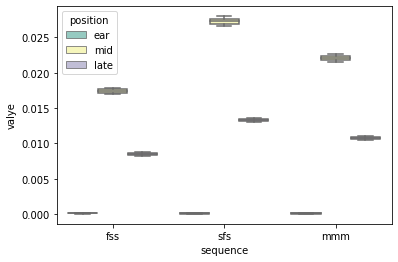

Mixed selectivity:  151


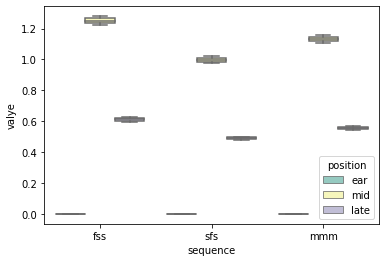

Mixed selectivity:  152


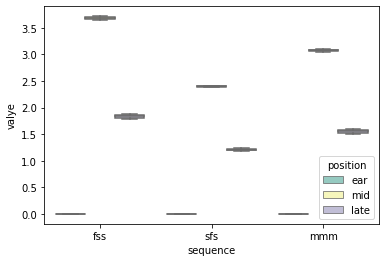

Mixed selectivity:  153


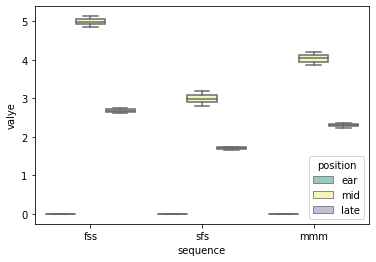

Mixed selectivity:  157


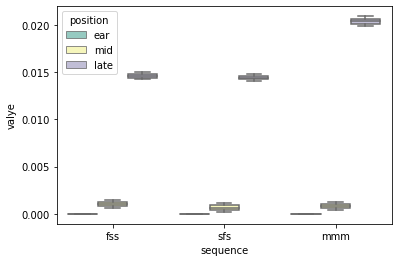

Mixed selectivity:  158


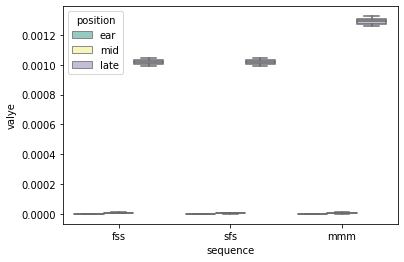

Mixed selectivity:  162


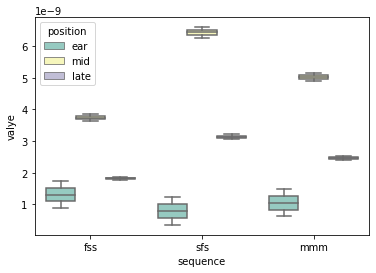

Mixed selectivity:  163


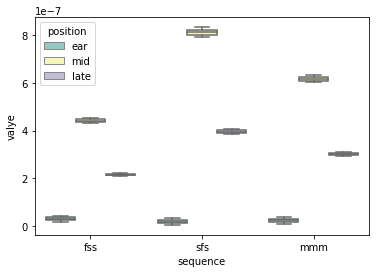

Mixed selectivity:  164


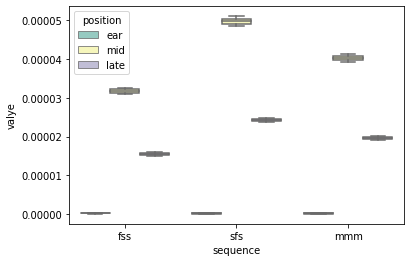

Mixed selectivity:  166


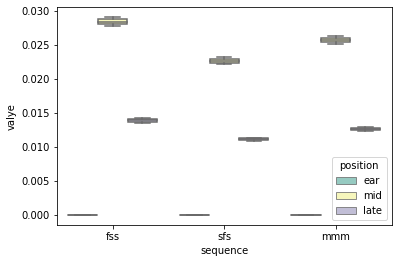

Mixed selectivity:  167


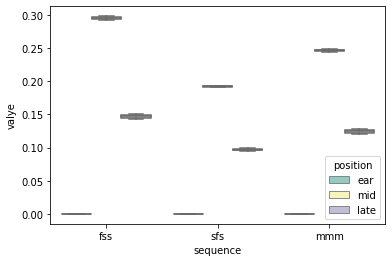

Mixed selectivity:  168


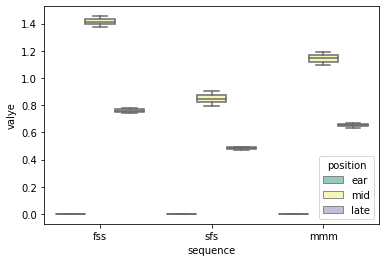

Mixed selectivity:  172


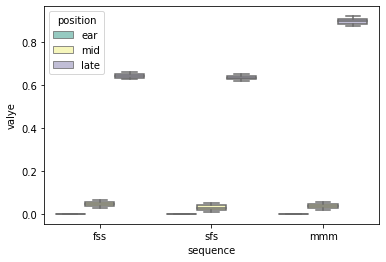

Mixed selectivity:  173


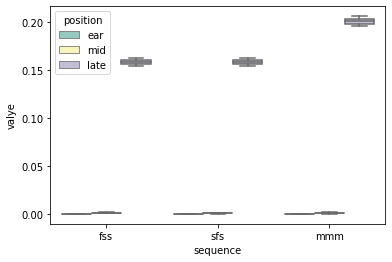

Mixed selectivity:  177


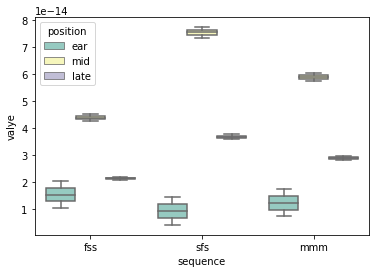

Mixed selectivity:  178


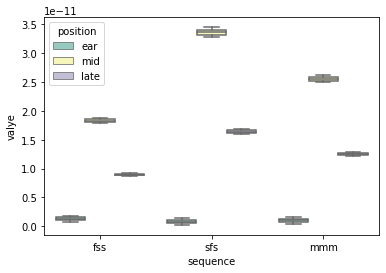

Mixed selectivity:  179


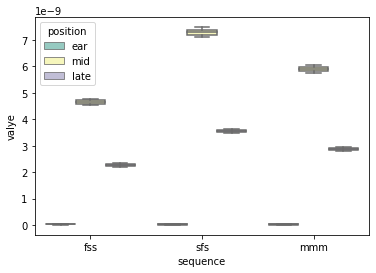

Mixed selectivity:  181


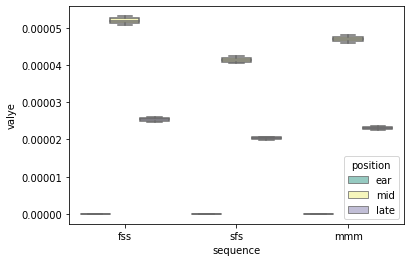

Mixed selectivity:  182


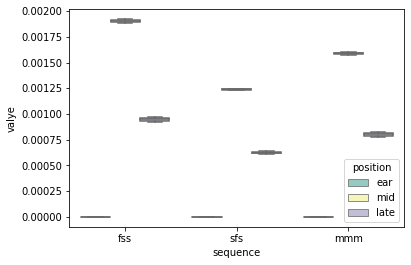

Mixed selectivity:  183


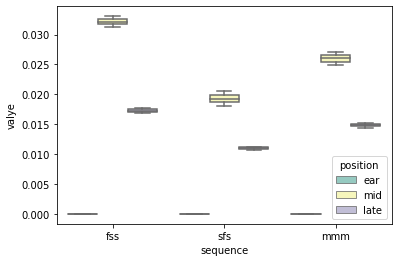

Mixed selectivity:  187


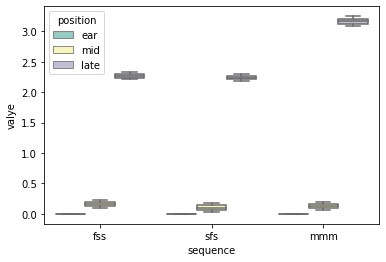

Mixed selectivity:  188


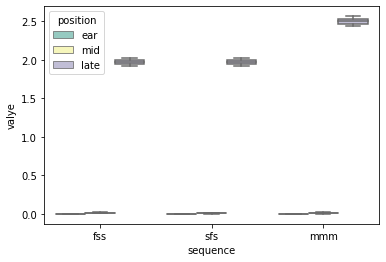

Mixed selectivity:  191


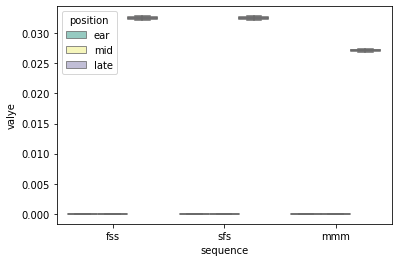

Mixed selectivity:  192


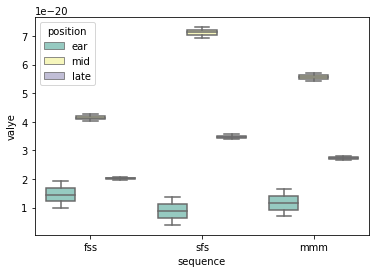

Mixed selectivity:  193


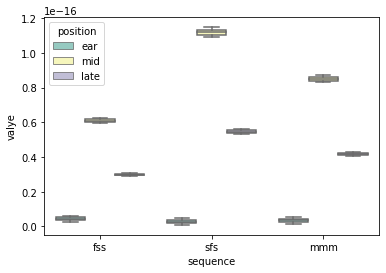

Mixed selectivity:  194


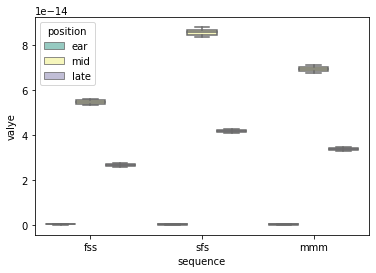

Mixed selectivity:  196


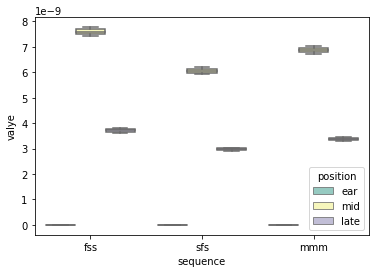

Mixed selectivity:  197


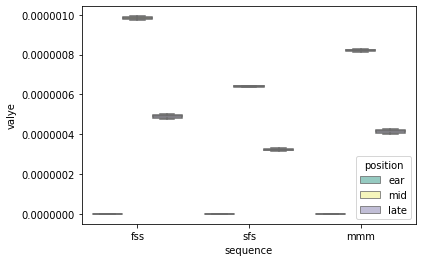

Mixed selectivity:  198


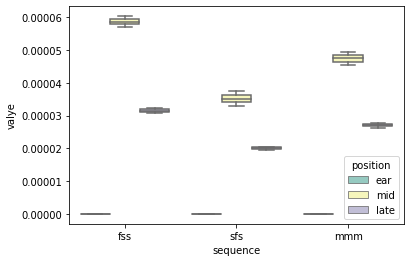

Mixed selectivity:  202


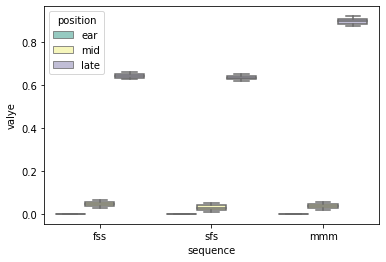

Mixed selectivity:  203


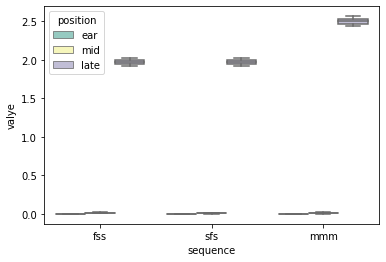

Mixed selectivity:  206


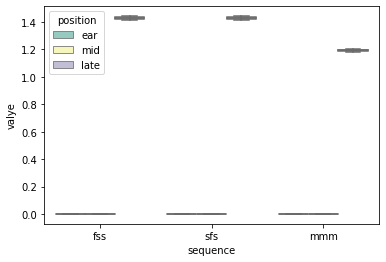

Mixed selectivity:  207


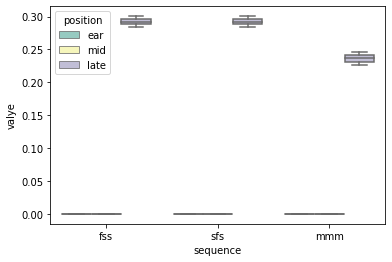

Mixed selectivity:  208


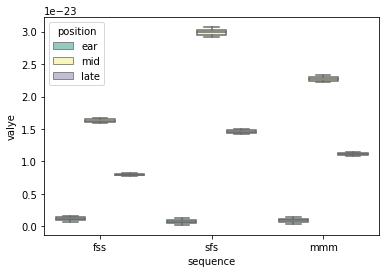

Mixed selectivity:  209


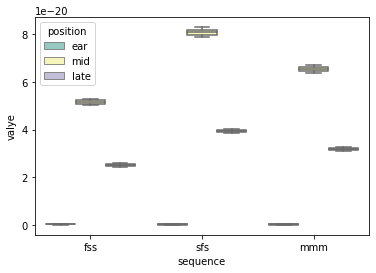

Mixed selectivity:  211


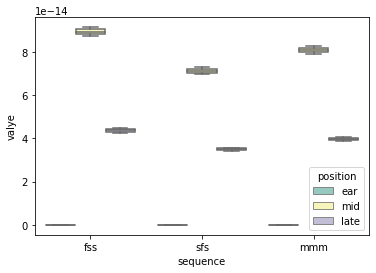

Mixed selectivity:  212


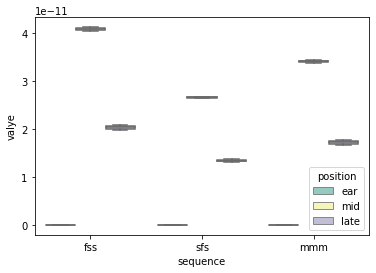

Mixed selectivity:  213


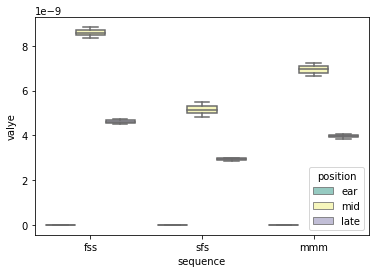

Mixed selectivity:  217


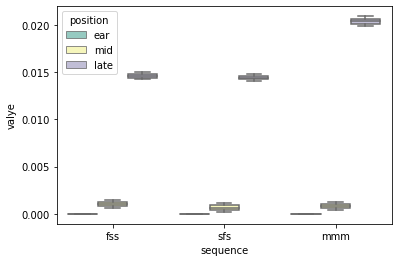

Mixed selectivity:  218


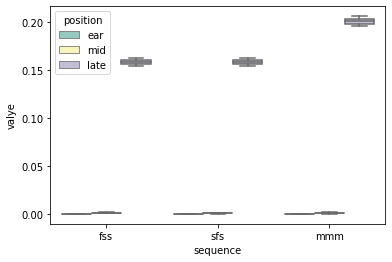

Mixed selectivity:  221


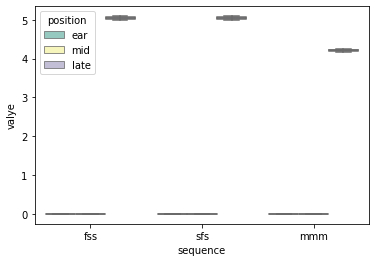

Mixed selectivity:  222


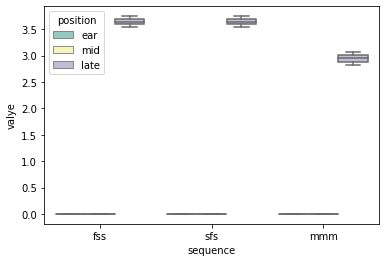

Mixed selectivity:  224


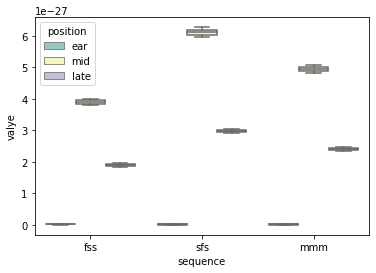

Mixed selectivity:  226


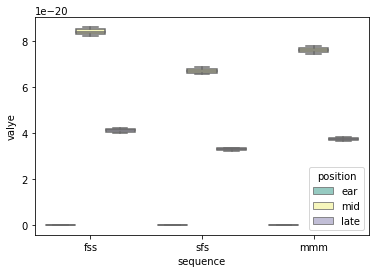

Mixed selectivity:  227


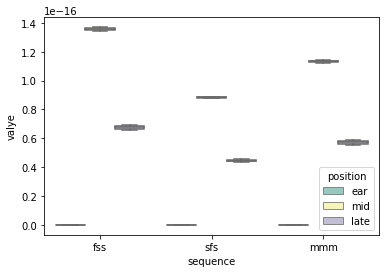

Mixed selectivity:  228


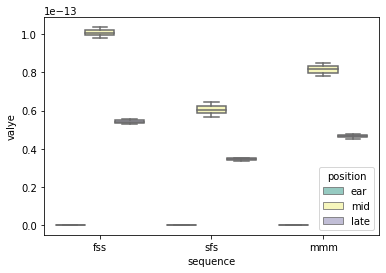

Mixed selectivity:  232


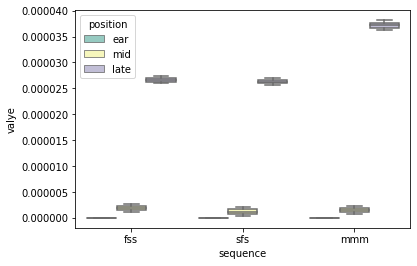

Mixed selectivity:  233


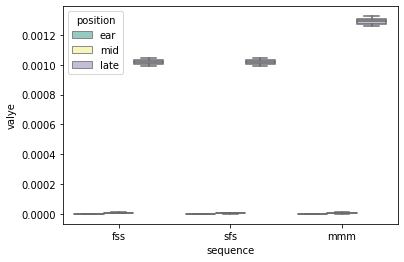

Mixed selectivity:  236


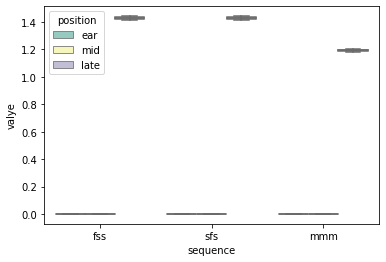

Mixed selectivity:  237


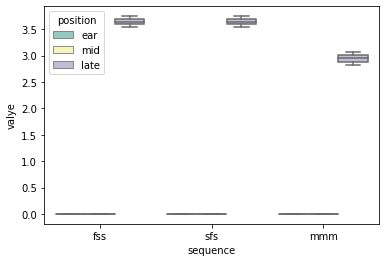

Mixed selectivity:  241


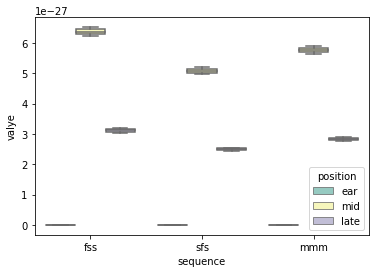

Mixed selectivity:  242


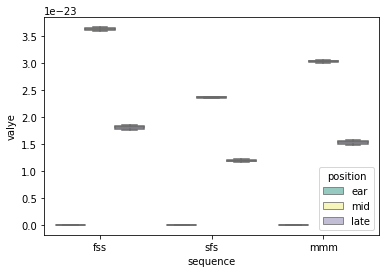

Mixed selectivity:  243


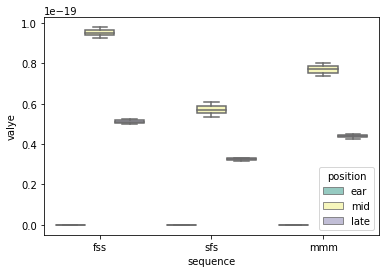

Mixed selectivity:  247


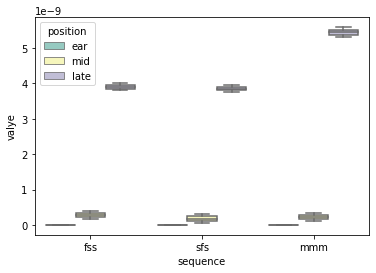

Mixed selectivity:  248


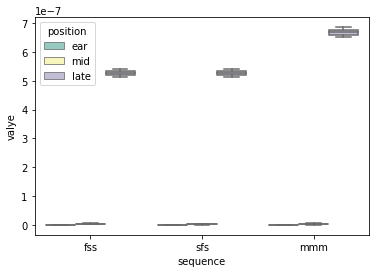

Mixed selectivity:  251


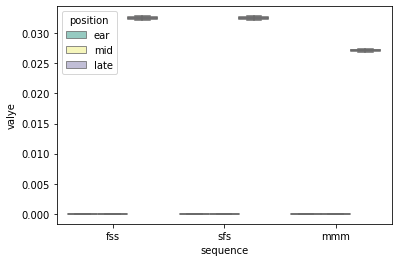

Mixed selectivity:  252


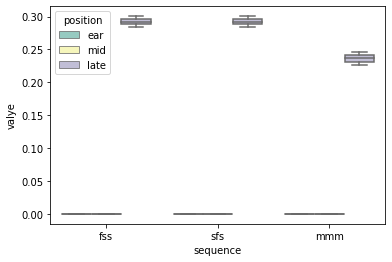

Linear Integrator
p-unc 0.01
position effect    :  256
sequence effec    t:  193
pos*seq interaction:  158
shape changer      :  0


In [34]:
p_count=0
s_count=0
ps_count=0
sc_count=0
#sign = 0.001
factor ='p-unc'#'p-GG-corr'
for neuron in range(256):
    for i in range(18):
        df.loc[i,'valye']=stat_data_li[neuron,i]
    #print("Neuron", neuron)
        
#    res = pg.rm_anova(dv='valye', within=['position', 'sequence'], subject='subject', 
#                  data=df, detailed=True)

    res = pg.anova(dv='valye', between=['position', 'sequence'], 
                  data=df, detailed=True)
    if res.loc[0,factor] < sign:
        p_count = p_count +1

    if res.loc[1,factor] < sign:
        s_count = s_count +1

    if res.loc[2,factor] < sign:
        print("Mixed selectivity: ", neuron)
        ps_count = ps_count +1  
        sns.boxplot(hue="position", y="valye", x="sequence", data=df, palette="Set3")
        plt.show()

        if is_shapechanger(df):
            sc_count = sc_count + 1
            print('shape changer')
            sns.boxplot(hue="position", y="valye", x="sequence", data=df, palette="Set3")
            plt.show()
            print("Shape changer: ", neuron)



    #if res.loc[0,factor] < sign and res.loc[1,factor] < sign and np.mean(stat_data_li[neuron,:]) > 0:
    #    print("Two way main effect neuron: ", neuron)
    #    sns.boxplot(hue="position", y="valye", x="sequence", data=df, palette="Set3")
    #    plt.show()
 
print('Linear Integrator')
print(factor, sign)
print("position effect    : ",p_count)       
print("sequence effec    t: ",s_count)       
print("pos*seq interaction: ",ps_count)  
print("shape changer      : ",sc_count)

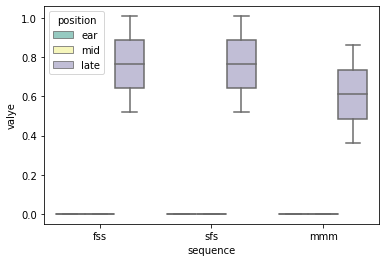

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.boxplot(hue="position", y="valye", x="sequence", data=df, palette="Set3")
plt.show()

In [36]:
print(df)

   subject position sequence         valye speed
0       s1      ear      fss  1.755563e-55  fast
1       s1      mid      fss  2.904043e-17  slow
2       s1     late      fss  5.180761e-01  slow
3       s2      ear      fss  8.895550e-53  fast
4       s2      mid      fss  8.654058e-16  slow
5       s2     late      fss  1.008667e+00  slow
6       s1      ear      sfs  1.073281e-57  slow
7       s1      mid      sfs  1.676813e-18  fast
8       s1     late      sfs  5.180761e-01  slow
9       s2      ear      sfs  8.878974e-53  slow
10      s2      mid      sfs  8.394104e-16  fast
11      s2     late      sfs  1.008667e+00  slow
12      s1      ear      mmm  2.874042e-56   med
13      s1      mid      mmm  1.051427e-17   med
14      s1     late      mmm  3.621358e-01   med
15      s2      ear      mmm  8.881602e-53   med
16      s2      mid      mmm  8.478060e-16   med
17      s2     late      mmm  8.605239e-01   med


In [37]:
data=df['valye'].tolist()

In [38]:

print(data)

[1.755562579954255e-55, 2.9040427616022435e-17, 0.5180761495842106, 8.895549778266493e-53, 8.654058428289145e-16, 1.0086672399281074, 1.0732811479118627e-57, 1.676812656648155e-18, 0.5180761495842104, 8.878973895465979e-53, 8.394104086175089e-16, 1.0086672399281071, 2.8740419890384194e-56, 1.0514267698101361e-17, 0.3621358324223884, 8.881602273646515e-53, 8.478059909068895e-16, 0.8605239386243763]


In [39]:
print(df)

   subject position sequence         valye speed
0       s1      ear      fss  1.755563e-55  fast
1       s1      mid      fss  2.904043e-17  slow
2       s1     late      fss  5.180761e-01  slow
3       s2      ear      fss  8.895550e-53  fast
4       s2      mid      fss  8.654058e-16  slow
5       s2     late      fss  1.008667e+00  slow
6       s1      ear      sfs  1.073281e-57  slow
7       s1      mid      sfs  1.676813e-18  fast
8       s1     late      sfs  5.180761e-01  slow
9       s2      ear      sfs  8.878974e-53  slow
10      s2      mid      sfs  8.394104e-16  fast
11      s2     late      sfs  1.008667e+00  slow
12      s1      ear      mmm  2.874042e-56   med
13      s1      mid      mmm  1.051427e-17   med
14      s1     late      mmm  3.621358e-01   med
15      s2      ear      mmm  8.881602e-53   med
16      s2      mid      mmm  8.478060e-16   med
17      s2     late      mmm  8.605239e-01   med


In [40]:
is_shapechanger(df)


False